# MACHINE LEARNING APPROACH

Student 1: Sara Martín (NIU:1669812)

Student 2: Amelia Gomez (NIU:1631745)

Student 3: Aina Navarro (NIU:1670797)

Student 4: Lara Rodríguez (NIU: 1667906)

## Downloads, libraries and functions

In [1]:
!git clone https://github.com/saraxmartin/NegExES.git
%cd "/content/NegExES"
!git pull

Cloning into 'NegExES'...
remote: Enumerating objects: 204, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 204 (delta 13), reused 2 (delta 2), pack-reused 169
Receiving objects: 100% (204/204), 3.64 MiB | 7.14 MiB/s, done.
Resolving deltas: 100% (107/107), done.
/content/NegExES
Already up to date.


In [ ]:
!pip install spacy
!pip install pyspellchecker
!pip install -U spacy
!pip install language-tool-python
!python -m spacy download es_core_news_sm
!pip install Levenshtein
!pip install sklearn_crfsuite

In [3]:
import os
import re
import unicodedata
import json
import spacy
import random
import xml.etree.ElementTree as ET
import nltk
nltk.download("punkt")
nltk.download('wordnet')
import string
import Levenshtein
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from spellchecker import SpellChecker
import language_tool_python
# Load the Spanish language model from spaCy
nlp = spacy.load("es_core_news_sm")
import numpy as np
import pandas as pd
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import sklearn
import copy

import sklearn_crfsuite
from sklearn_crfsuite import metrics
from sklearn_crfsuite import scorers
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [4]:
def text_to_sentences(text):
    sent_text = nltk.sent_tokenize(text)
    return sent_text

def remove_punctuation(sentence):
    sentence_no_punct = sentence.translate(str.maketrans("", "", string.punctuation))
    return sentence_no_punct

def sentence_to_words(sentence):
    tokenized_sentence = nltk.word_tokenize(sentence)
    return tokenized_sentence

def join_sentence(words):
    sentence = ""
    for i, word in enumerate(words):
        if i == 0:
            sentence += word
        else:
            sentence += " " + word
    return sentence

In [5]:
def correct_mispellings(words, language):
    # Initialize a spell checker for Spanish
    corrected_words = []
    if language=="es":
      with language_tool_python.LanguageToolPublicAPI('es') as tool:
        for word in words:
          corrected = tool.correct(word)
          corrected_words.append(corrected.lower())
    elif language=="cat":
      with language_tool_python.LanguageToolPublicAPI('ca-ES') as tool:
        for word in words:
          corrected = tool.correct(word)
          corrected_words.append(corrected.lower())

    return corrected_words

def correct_mispelling_normal_word(word):
  spell = SpellChecker(language='es')

  if word in spell: # if there is NOT a mispelling
    return word
  else:
    correct_word = spell.correction(word)
    return correct_word

def correct_mispelling(word, medicalterms):
  spell = SpellChecker(language='es')

  if len(word) == 1:
      if word in spell: # if there is NOT a mispelling
        return word
      else: # if the word is not in spell
        if word in medicalterms:
          return word
        else:

          # find the closest word of w in medicalterms
          best = ""
          max = 0
          for term in medicalterms:
            temporal = Levenshtein.distance(word, term)
            if max < temporal:
              max = temporal
              best = term
          correct_word = spell.correction(word)
          print(f"{word} should be spell:{correct_word}, distance:{best}")
          return best

  else: # the entered word consist of more than one word
    list_words = word.split() # splitting the input for each word
    original = ""
    for w in list_words: # iterating through all the words
        if w in spell: # if there is NOT a mispelling
          original += w + " "
        else: # if word not in spellchecker
          if w in medicalterms: # if word in medicalterms
            original += w + " "
          else: # the word is a mispelling

            # find the closest word of w in medicalterms
            best = ""
            max = 0
            for term in medicalterms:
              for t in term:
                temporal = Levenshtein.distance(word, t)
                if max < temporal:
                  max = temporal
                  best = term
            correct_word = spell.correction(word)
            print(f"{w} should be spell:{correct_word}, distance:{best}")
            original += best + " "

    return original

def lemmatize(words):
  lemmatizer = WordNetLemmatizer()
  lemmatized_words = []
  for word in words:
    lemmatized_words.append(lemmatizer.lemmatize(word))

  return lemmatized_words

def stem(words):
  ps = PorterStemmer()
  stem_words = []
  for word in words:
    stem_words.append(ps.stem(word))

  return stem_words

def has_letters(word):
    for char in word:
        if char.isalpha():
            return True
    return False

def remove_punctuation(word):
    if not has_letters(word):
        return word
    new_word =""
    for char in word:
        if char.islower():
            new_word += char
    return new_word

# Data pre-processing


#### Import the data (JSON), create training and test datasets and create list of trigger words (negations and uncertainity words)


In [6]:
train_data_path = "/content/NegExES/data/negacio_train_v2024.json"
test_data_path = "/content/NegExES/data/negacio_test_v2024.json"

# Read files
with open(train_data_path, 'r') as file:
    train_json_data = file.read()
    train_data = json.loads(train_json_data)

with open(test_data_path, 'r') as file:
    test_json_data = file.read()
    test_data = json.loads(test_json_data)

# Initialize lists
neg, unc, medicalterms = [],[],[]

def extract_data(data, train=False):
    """
    Extracts the data from the JSON file.
    Returns:
        corpus: list of texts
        ground_truth: list of dictionaries (one for each text)
            with the true labels for negations/uncertainities and
            their scopes.
    """
    corpus = []
    ground_truth = []
    for item in data:
        text = item['data']['text']
        corpus.append(text)
        predictions = item['predictions']
        text_gt = {"NEG":[],"UNC":[],"NSCO":[],"USCO":[]}
        for prediction in predictions:
            for result in prediction['result']:
                value = result['value']
                start = value['start']
                end = value['end']
                labels = value['labels']
                extracted_text = text[start:end]
                for label in labels:
                    if (label == "NEG") and (extracted_text not in neg) and train:
                          neg.append(extracted_text)
                    elif (label == "UNC") and (extracted_text not in unc) and train:
                          unc.append(extracted_text)
                    elif ((label == "NSCO") or (label == "USCO")) and (extracted_text not in medicalterms) and train:
                          medicalterms.append(extracted_text)
                    text_gt[label].append((start,end))

            ground_truth.append(text_gt)

    return corpus, ground_truth

x_train, gt_train = extract_data(train_data, train=True)
x_test, gt_test = extract_data(test_data, train=False)

print("Length negations:", len(neg))
print("Length uncertainty:", len(unc))
print("Length medical terms:", len(medicalterms))
print("Length training data:", len(x_train))
print("Length test data:", len(x_test))

Length negations: 98
Length uncertainty: 84
Length medical terms: 2955
Length training data: 254
Length test data: 64


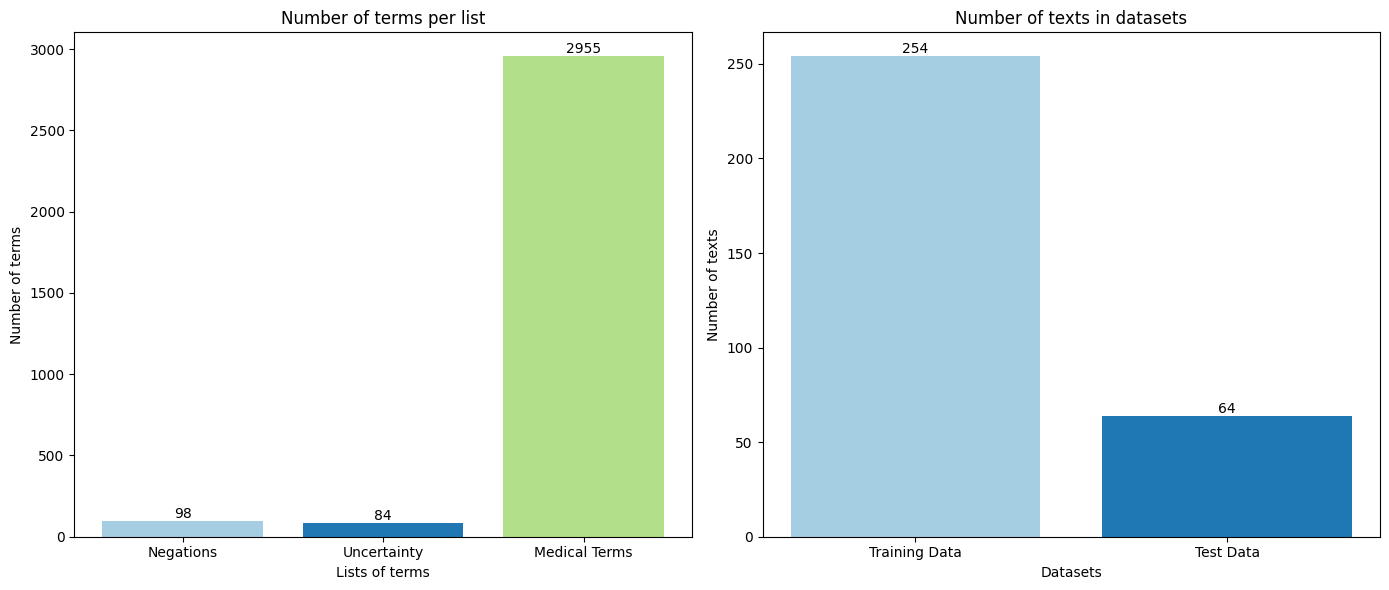

In [7]:
# Visualization of datasets
colors = sns.color_palette("Paired",4)

# Plot 1: Number of terms per list
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
data_plot = [len(neg), len(unc), len(medicalterms)]
bars = plt.bar(['Negations', 'Uncertainty', 'Medical Terms'], data_plot, color=colors)
plt.xlabel('Lists of terms')
plt.ylabel('Number of terms')
plt.title('Number of terms per list')
for bar, number in zip(bars, data_plot):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05, str(number), ha='center', va='bottom')

# Plot 2: Number of texts in datasets
plt.subplot(1, 2, 2)
data_plot = [len(x_train), len(x_test)]
bars = plt.bar(['Training Data', 'Test Data'], data_plot, color=colors)
plt.xlabel('Datasets')
plt.ylabel('Number of texts')
plt.title('Number of texts in datasets')
for bar, number in zip(bars, data_plot):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05, str(number), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [8]:
# Create y_train and y_test from gt_train and gt_test

def get_token_indices(text):
    tokens = nltk.word_tokenize(text)
    indices = []
    current_index = 0
    for token in tokens:
        start = text.find(token, current_index)
        end = start + len(token)
        indices.append((start, end))
        current_index = end
    return tokens, indices

def is_within_indices(index,indices_list):
    for idx in indices_list:
        if idx[0] <= index[0] <= idx[1] and idx[0] <= index[1] <= idx[1]:
            return True
    return False

def create_y_data(text_indices,gt):
    y_data = []
    for index in text_indices:
        if is_within_indices(index,gt["NEG"]):
            y_data.append("NEG")
        elif is_within_indices(index,gt["UNC"]):
            y_data.append("UNC")
        elif is_within_indices(index,gt["NSCO"]):
            y_data.append("NSCO")
        elif is_within_indices(index,gt["USCO"]):
            y_data.append("USCO")
        else:
            y_data.append("O")
    return y_data

X_train_tokens = []
X_train_tokenindex = []
y_train = []
for i,text in enumerate(x_train):
    text_tokens, text_indices = get_token_indices(text)
    X_train_tokenindex.append(text_indices)
    X_train_tokens.append(text_tokens)
    y_data = create_y_data(text_indices,gt_train[i])
    y_train.append(y_data)

X_test_tokens = []
X_test_tokenindex = []
y_test = []
for i,text in enumerate(x_test):
    text_tokens, text_indices = get_token_indices(text)
    X_test_tokenindex.append(text_indices)
    X_test_tokens.append(text_tokens)
    y_data = create_y_data(text_indices,gt_test[i])
    y_test.append(y_data)

#### BIO Tagging and BIESO tagging

In [9]:
import sys
sys.path.append('/content/NegExES/')

from bio_bieso_tagging import BIO_tagging, BIESO_tagging

y_train_bio = BIO_tagging(y_train)
y_test_bio = BIO_tagging(y_test)

y_train_bieso = BIESO_tagging(y_train)
y_test_bieso = BIESO_tagging(y_test)

#### Change format of train and test sets

In [10]:
# Pass to format (word, label)
def pairs_format(X_train_tokens, X_test_tokens, y_train, y_test):
  train_set = []
  for i in range(len(X_train_tokens)):
    pairs = []
    for word,label in zip(X_train_tokens[i],y_train[i]):
      pairs.append((word, label))
    train_set.append(pairs)

  test_set = []
  for i in range(len(X_test_tokens)):
    pairs = []
    for word,label in zip(X_test_tokens[i],y_test[i]):
      pairs.append((word, label))
    test_set.append(pairs)

  return train_set, test_set

In [11]:
train_set, test_set = pairs_format(X_train_tokens, X_test_tokens, y_train, y_test)
train_set_bio, test_set_bio = pairs_format(X_train_tokens, X_test_tokens, y_train_bio, y_test_bio)
train_set_bieso, test_set_bieso = pairs_format(X_train_tokens, X_test_tokens, y_train_bieso, y_test_bieso)

## Final dataset

### Useful functions

In [12]:
# Extract features from a given sentence
def word_features(sent, i):
    word = sent[i][0]
    pos = sent[i][1]

    # first word
    if i==0:
        prevword = '<START>'
        prevpos = '<START>'
    else:
        prevword = sent[i-1][0]
        prevpos = sent[i-1][1]

    """# first word
    if i==0 or i==1:
        prev2word = '<START>'
        prev2pos = '<START>'
    else:
        prev2word = sent[i-2][0]
        prev2pos = sent[i-2][1]"""

    # last word
    if i == len(sent)-1:
        nextword = '<END>'
        nextpos = '<END>'
    else:
        nextword = sent[i+1][0]
        nextpos = sent[i+1][1]

    # suffixes and prefixes
    pref_1, pref_2, pref_3, pref_4 = word[:1], word[:2], word[:3], word[:4]
    suff_1, suff_2, suff_3, suff_4 = word[-1:], word[-2:], word[-3:], word[-4:]

    return {'word':word,
            'prevword': prevword,
            'prevpos': prevpos,
            'nextword': nextword,
            'nextpos': nextpos,
            'suff_1': suff_1,
            'suff_2': suff_2,
            'suff_3': suff_3,
            'suff_4': suff_4,
            'pref_1': pref_1,
            'pref_2': pref_2,
            'pref_3': pref_3,
            'pref_4': pref_4
            #'prev2word': prev2word,
            #'prev2pos': prev2pos
           }

In [13]:
# Defining functions to extract featrues, postags and words from sentences

def sent2features(sent):
    return [word_features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [postag for word, postag in sent]

def sent2tokens(sent):
    return [word for word, postag in sent]

In [14]:
X_train = [sent2features(s) for s in train_set]
y_train = [sent2labels(s) for s in train_set]

# X_valid = [sent2features(s) for s in val_set]
# y_valid = [sent2labels(s) for s in val_set]

X_test = [sent2features(s) for s in test_set]
y_test = [sent2labels(s) for s in test_set]

In [15]:
X_train_bio = [sent2features(s) for s in train_set_bio]
y_train_bio = [sent2labels(s) for s in train_set_bio]

# X_valid = [sent2features(s) for s in val_set]
# y_valid = [sent2labels(s) for s in val_set]

X_test_bio = [sent2features(s) for s in test_set_bio]
y_test_bio = [sent2labels(s) for s in test_set_bio]

In [16]:
X_train_bieso = [sent2features(s) for s in train_set_bieso]
y_train_bieso = [sent2labels(s) for s in train_set_bieso]

X_test_bieso = [sent2features(s) for s in test_set_bieso]
y_test_bieso = [sent2labels(s) for s in test_set_bieso]

### Plots

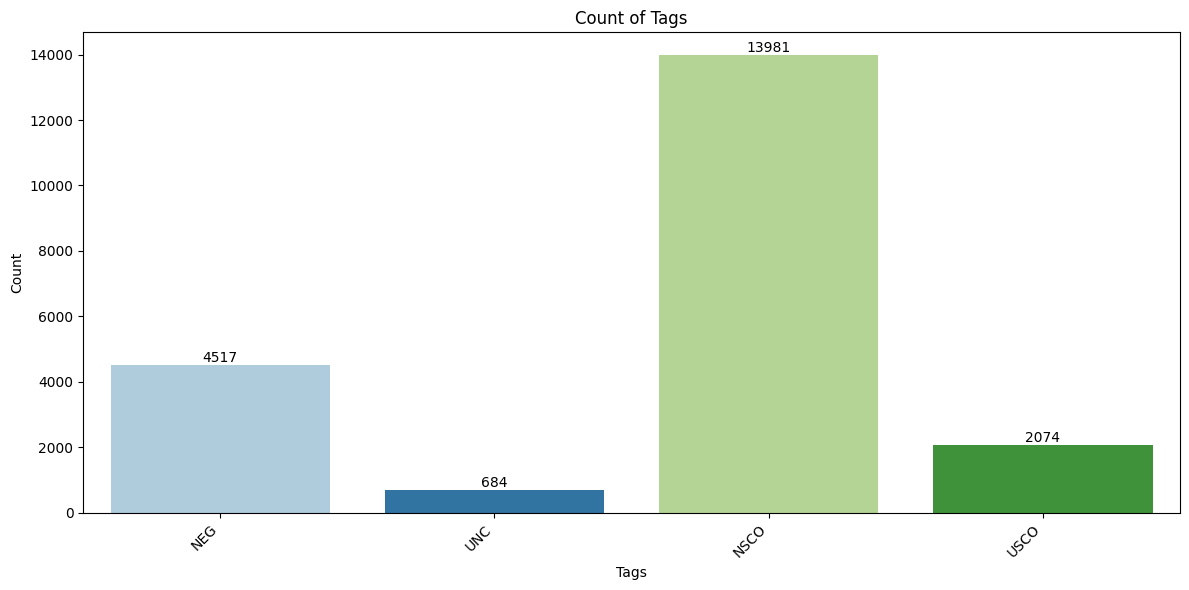

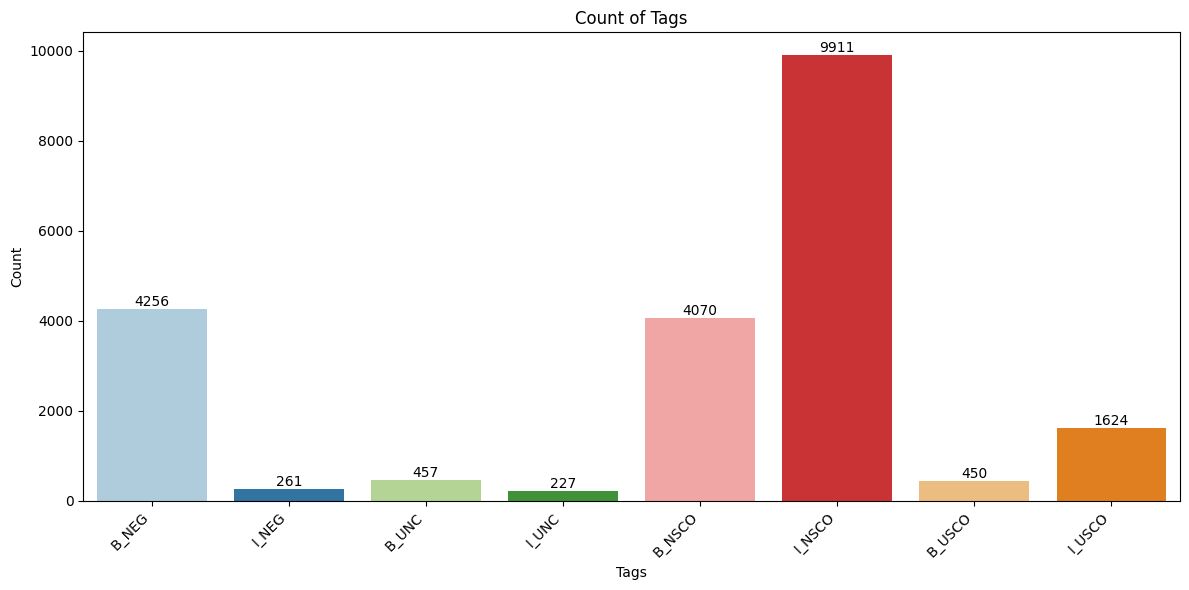

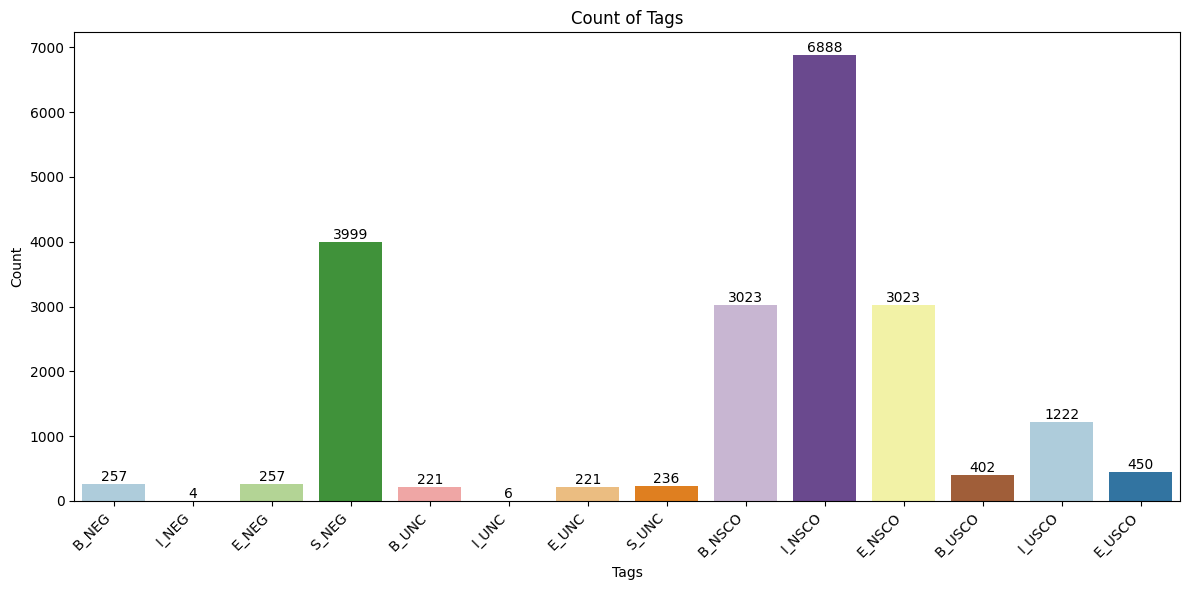

In [17]:
from collections import Counter

# New lists to plot (flatten and filter "O" tag)
plot_y_train = sum(y_train,[])
plot_y_train = list(filter(lambda x: x != 'O', plot_y_train))
plot_y_train_bio = sum(y_train_bio,[])
plot_y_train_bio = list(filter(lambda x: x != 'O', plot_y_train_bio))
plot_y_train_bieso = sum(y_train_bieso,[])
plot_y_train_bieso = list(filter(lambda x: x != 'O', plot_y_train_bieso))

# Your list of tags
tags_1 = ['NEG', 'UNC', 'NSCO','USCO']
tags_2 = ['B_NEG', 'I_NEG', 'B_UNC', 'I_UNC', 'B_NSCO', 'I_NSCO', 'B_USCO', 'I_USCO']
tags_3 = ['B_NEG', 'I_NEG', 'E_NEG', 'S_NEG','B_UNC', 'I_UNC', 'E_UNC', 'S_UNC', 'B_NSCO',
          'I_NSCO', 'E_NSCO','B_USCO', 'I_USCO', 'E_USCO']

def plot_tags(tags,data):
    # Count occurrences of each tag
    tag_counts = Counter(data)

    # Create bar plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x=tags, y=[tag_counts[tag] for tag in tags], palette='Paired', hue=tags, dodge=False)

    # Display exact count on top of each bar
    for i, count in enumerate([tag_counts[tag] for tag in tags]):
        plt.text(i, count, str(count), ha='center', va='bottom')

    plt.xlabel('Tags')
    plt.ylabel('Count')
    plt.title('Count of Tags')
    plt.xticks(rotation=45, ha='right')
    plt.legend([], [], frameon=False)  # Hide legend
    plt.tight_layout()
    plt.show()

plot_tags(tags_1,plot_y_train)
plot_tags(tags_2,plot_y_train_bio)
plot_tags(tags_3,plot_y_train_bieso)

# MODELS

## CRF

### Baseline

In [ ]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.01,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
    )

In [ ]:
crf.fit(X_train, y_train)
labels = list(crf.classes_)

### BIO Tagging

In [ ]:
crf_bio = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.01,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
    )

In [ ]:
crf_bio.fit(X_train_bio, y_train_bio)
labels_bio = list(crf.classes_)

### BIESO Tagging

In [ ]:
crf_bieso = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.01,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
    )

In [ ]:
crf_bieso.fit(X_train_bieso, y_train_bieso)
labels_bieso = list(crf.classes_)

## HMM

### Preprocess


In [ ]:
def process_points(t_set):
  t_set_copy = copy.deepcopy(t_set)
  for sent in range(len(t_set)):
    for tup in range(len(t_set[sent])):
      if t_set[sent][tup][0]=='.':
        t_set_copy[sent][tup] = ('.','.')

  return t_set_copy

In [ ]:
train_set_hmm = process_points(train_set)
test_set_hmm = process_points(test_set)

In [ ]:
# list of tagged words
train_tagged_words = [tup for sent in train_set_hmm for tup in sent]

# tokens
tokens = [pair[0] for pair in train_tagged_words]

# vocabulary
V = set(tokens)

# number of tags
T = set([pair[1] for pair in train_tagged_words])

### Emission probabilities (probability of a word given a tag)

In [ ]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [ ]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
  tag_list = [pair for pair in train_bag if pair[1]==tag]
  count_tag = len(tag_list)
  w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
  count_w_given_tag = len(w_given_tag_list)

  return (count_w_given_tag, count_tag)

### Transition probabilities (probability of getting a tag t2 given that the tag for previous word was t1)

In [ ]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [ ]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
  for j, t2 in enumerate(list(T)):
    tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [ ]:
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [ ]:
tags_df

,USCO,.,NEG,NSCO,UNC,O
USCO,0.759467,0.133867,0.007467,0.000000,0.008533,0.090667
.,0.000170,0.000424,0.086650,0.009505,0.003140,0.900110
NEG,0.000227,0.063661,0.035569,0.826235,0.000000,0.074309
NSCO,0.000076,0.179804,0.028374,0.690236,0.000228,0.101282
UNC,0.650442,0.011799,0.000000,0.002950,0.325959,0.008850
O,0.000028,0.041467,0.013317,0.001506,0.001875,0.941802


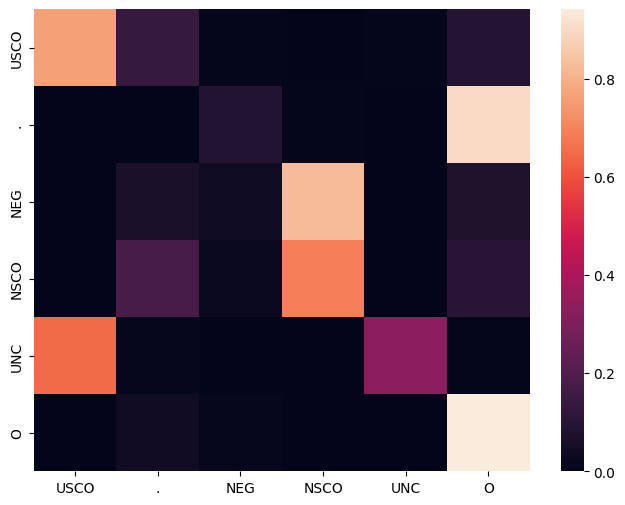

In [ ]:
import seaborn as sns

# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(8,6))
sns.heatmap(tags_df)
plt.show()

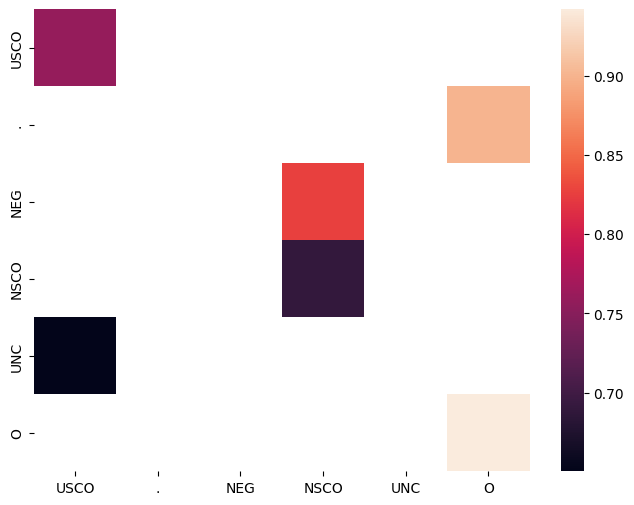

In [ ]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(8, 6))
sns.heatmap(tags_frequent)
plt.show()

### Viterbi algorithm

In [ ]:
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))

    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = []
        for tag in T:
            if key == 0:
              transition_p = tags_df.loc['.', tag]
            else:
              transition_p = tags_df.loc[state[-1], tag]

            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p
            p.append(state_probability)

        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)]
        state.append(state_max)
    return list(zip(words, state))

In [ ]:
# Running the Viterbi algorithm on a few sample sentences
# since running it on the entire data set will take many hours

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set_hmm)) for x in range(5)]

# list of sents
test_run = [test_set_hmm[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]

In [ ]:
tagged_seq = Viterbi(test_tagged_words)

## SVM (USING SVC)

In [25]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.svm import LinearSVC

def train_svm(X_train, y_train, X_test, y_test):
  # Flatten the training and test data
  # X_train_flat is a list of features for each word across all sentences
  # y_train_flat is a list of labels for each word across all sentences
  X_train_flat = [feature for sentence in X_train for feature in sentence]
  y_train_flat = [label for sentence in y_train for label in sentence]

  X_test_flat = [feature for sentence in X_test for feature in sentence]
  y_test_flat = [label for sentence in y_test for label in sentence]

  # Initialize the DictVectorizer and transform the feature data
  vectorizer = DictVectorizer(sparse=True)
  X_train_matrix = vectorizer.fit_transform(X_train_flat)
  X_test_matrix = vectorizer.transform(X_test_flat)

  # Train the LinearSVC model is a linear Support Vector Machine (SVM) classifier from the sklearn.svm module.
  #It is an effective model for classification tasks, particularly when you have a large number of features and require a fast training time
  svm_model = LinearSVC()
  svm_model.fit(X_train_matrix, y_train_flat)

  # Predict using the model
  y_pred = svm_model.predict(X_test_matrix)

  return y_test_flat, y_pred


## MULTINOMIAL NAÏVE BAYES

### MULTINOMIAL NB USING DICTVECTORIZER

In [18]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import pipeline
from sklearn import feature_extraction

In [19]:
def train_mnb_with_dict_vector(X_train, y_train, X_test, y_test):
  X_train_flat = [feature for sentence in X_train for feature in sentence]
  y_train_flat = [label for sentence in y_train for label in sentence]

  X_test_flat = [feature for sentence in X_test for feature in sentence]
  y_test_flat = [label for sentence in y_test for label in sentence]

  vectorizer = DictVectorizer(sparse=True)
  pipe_mnb = pipeline.Pipeline([
      ('vectorizer', vectorizer),
      ('clf', MultinomialNB())
  ])
  pipe_mnb.fit(X_train_flat, y_train_flat)
  mnb_predicted = pipe_mnb.predict(X_test_flat)

  return y_test_flat, mnb_predicted

### MULTINOMIAL NB USING TFIDFVECTORIZER

In [20]:
def train_mnb_with_tfidf_vector(X_train, y_train, X_test, y_test):
  X_train_flat = [feature for sentence in X_train for feature in sentence]
  y_train_flat = [label for sentence in y_train for label in sentence]

  X_test_flat = [feature for sentence in X_test for feature in sentence]
  y_test_flat = [label for sentence in y_test for label in sentence]

  def dict_to_string(d):
    return ' '.join([f"{key}:{value}" for key, value in d.items()])

  X_train_str = [dict_to_string(d) for d in X_train_flat]
  X_test_str = [dict_to_string(d) for d in X_test_flat]
  vectorizer = feature_extraction.text.TfidfVectorizer(ngram_range=(1,3), analyzer='word')
  pipe_mnb = pipeline.Pipeline([
      ('vectorizer', vectorizer),
      ('clf', MultinomialNB())
  ])
  pipe_mnb.fit(X_train_str, y_train_flat)
  mnb_predicted = pipe_mnb.predict(X_test_str)

  return y_test_flat, mnb_predicted

## LOGISTIC REGRESSION

### LOGISIC REGRESSION WITH DICTVECTORIZER


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import pipeline
from sklearn import feature_extraction

In [ ]:
def train_lr_with_dict_vector(X_train, y_train, X_test, y_test):
  X_train_flat = [feature for sentence in X_train for feature in sentence]
  y_train_flat = [label for sentence in y_train for label in sentence]

  X_test_flat = [feature for sentence in X_test for feature in sentence]
  y_test_flat = [label for sentence in y_test for label in sentence]

  vectorizer = DictVectorizer(sparse=True)
  pipe_lr = pipeline.Pipeline([
      ('vectorizer', vectorizer),
      ('lr_clf', LogisticRegression(max_iter = 200))
  ])
  pipe_lr.fit(X_train_flat, y_train_flat)
  lr_predicted = pipe_lr.predict(X_test_flat)

  return y_test_flat, lr_predicted

### LOGISIC REGRESSION WITH TFIDFVECTORIZER

In [ ]:
def train_lr_with_tfidf_vector(X_train, y_train, X_test, y_test):
  X_train_flat = [feature for sentence in X_train for feature in sentence]
  y_train_flat = [label for sentence in y_train for label in sentence]

  X_test_flat = [feature for sentence in X_test for feature in sentence]
  y_test_flat = [label for sentence in y_test for label in sentence]
  def dict_to_string(d):
    return ' '.join([f"{key}:{value}" for key, value in d.items()])

  X_train_str = [dict_to_string(d) for d in X_train_flat]
  X_test_str = [dict_to_string(d) for d in X_test_flat]
  vectorizer = feature_extraction.text.TfidfVectorizer(ngram_range=(1,3), analyzer='word')
  pipe_lr = pipeline.Pipeline([
      ('vectorizer', vectorizer),
      ('lr_clf', LogisticRegression(max_iter = 200))
  ])
  pipe_lr.fit(X_train_str, y_train_flat)
  lr_predicted = pipe_lr.predict(X_test_str)

  return y_test_flat, lr_predicted

# EVALUATION

### Functions and libraries

In [21]:
import numpy as np
from itertools import chain
import pandas as pd
from tabulate import tabulate
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
import seaborn as sns

In [22]:
def plot_metrics(report_df, title):
    report_df = report_df.drop(columns=['support'])

    report_melted = report_df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Value')
    report_melted.rename(columns={'index': 'Class'}, inplace=True)

    min_value = report_melted['Value'].min()

    sns.set(style='whitegrid')
    plt.figure(figsize=(12, 8))

    # Create the barplot
    ax = sns.barplot(data=report_melted, x='Class', y='Value', hue='Metric', palette='Paired')

    # Set y-axis limits
    plt.ylim(min_value-0.01, 1)

    # Add labels and title
    plt.xlabel('Class')
    plt.ylabel('Value')
    plt.title(f'{title} Classification Report')

    # Rotate x labels if needed
    plt.xticks(rotation=45)

    # Show the plot
    plt.show()


def evaluate(y_true, y_pred, dataset, model):
    if len(y_true) != len(y_pred):
        print("Error: Lists are not of the same length.")
        return None
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=1)
    df_report = pd.DataFrame(report).transpose()
    print(f"\n{model} model evaluation for {dataset} dataset:")
    print(tabulate(df_report, headers='keys', tablefmt='grid'))
    plot_metrics(df_report,title = f"{model} model metrics for {dataset} dataset")

    return df_report

## Individual evaluations

In [23]:
def flatten(lista):
    lista = [item for row in lista for item in row]
    return lista

### CRF Baseline


CRF Baseline model evaluation for test dataset:
+--------------+-------------+----------+------------+--------------+
|              |   precision |   recall |   f1-score |      support |
+==============+=============+==========+============+==============+
| NEG          |    0.981897 | 0.965254 |   0.973504 |  1180        |
+--------------+-------------+----------+------------+--------------+
| NSCO         |    0.965096 | 0.929412 |   0.946918 |  3570        |
+--------------+-------------+----------+------------+--------------+
| O            |    0.994942 | 0.997243 |   0.996091 | 58388        |
+--------------+-------------+----------+------------+--------------+
| UNC          |    0.989418 | 0.935    |   0.96144  |   200        |
+--------------+-------------+----------+------------+--------------+
| USCO         |    0.942857 | 0.989418 |   0.965577 |   567        |
+--------------+-------------+----------+------------+--------------+
| accuracy     |    0.992598 | 0.992598 |

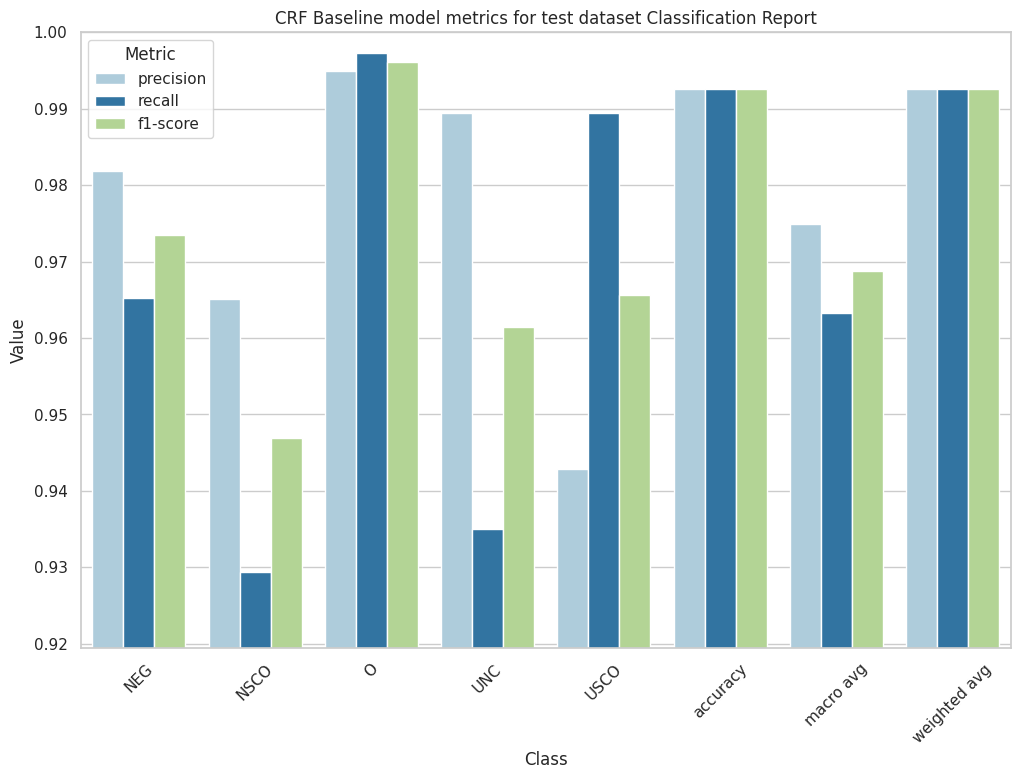

In [ ]:
# Evaluate on test data
y_pred_crf = crf.predict(X_test)
report_crf = evaluate(flatten(y_test),flatten(y_pred_crf),dataset="test",model="CRF Baseline")

### CRF BIO Tagging


CRF BIO model evaluation for test dataset:
+--------------+-------------+----------+------------+--------------+
|              |   precision |   recall |   f1-score |      support |
+==============+=============+==========+============+==============+
| B_NEG        |    0.994599 | 0.990143 |   0.992366 |  1116        |
+--------------+-------------+----------+------------+--------------+
| B_NSCO       |    0.992381 | 0.978404 |   0.985343 |  1065        |
+--------------+-------------+----------+------------+--------------+
| B_UNC        |    0.984733 | 0.977273 |   0.980989 |   132        |
+--------------+-------------+----------+------------+--------------+
| B_USCO       |    0.992308 | 1        |   0.996139 |   129        |
+--------------+-------------+----------+------------+--------------+
| I_NEG        |    0.677419 | 0.65625  |   0.666667 |    64        |
+--------------+-------------+----------+------------+--------------+
| I_NSCO       |    0.959064 | 0.916567 |   0.

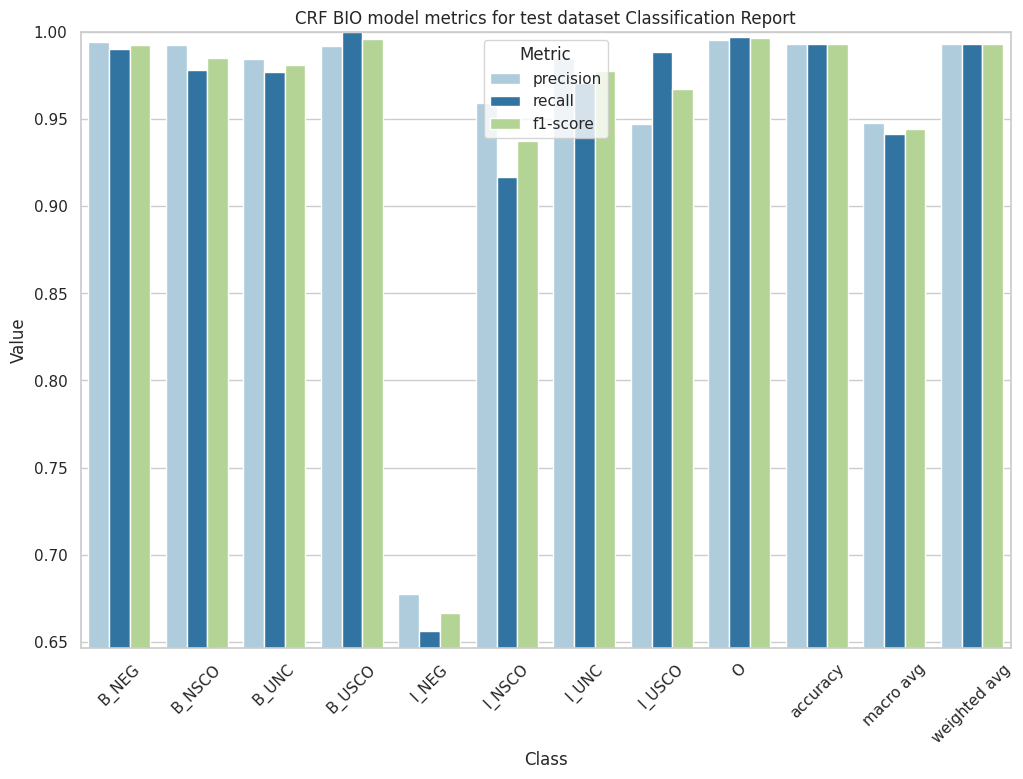

In [ ]:
# Evaluate on test data
y_pred_crf_bio = crf_bio.predict(X_test_bio)
report_crf_bio = evaluate(flatten(y_test_bio),flatten(y_pred_crf_bio),dataset="test",model='CRF BIO')

### CRF BIESO Tagging


CRF BIESO model evaluation for test dataset:
+--------------+-------------+----------+------------+--------------+
|              |   precision |   recall |   f1-score |      support |
+==============+=============+==========+============+==============+
| B_NEG        |    1        | 1        |   1        |    62        |
+--------------+-------------+----------+------------+--------------+
| B_NSCO       |    1        | 1        |   1        |   789        |
+--------------+-------------+----------+------------+--------------+
| B_UNC        |    0.983607 | 0.9375   |   0.96     |    64        |
+--------------+-------------+----------+------------+--------------+
| B_USCO       |    0.991379 | 1        |   0.995671 |   115        |
+--------------+-------------+----------+------------+--------------+
| E_NEG        |    0.983871 | 0.983871 |   0.983871 |    62        |
+--------------+-------------+----------+------------+--------------+
| E_NSCO       |    1        | 1        |   

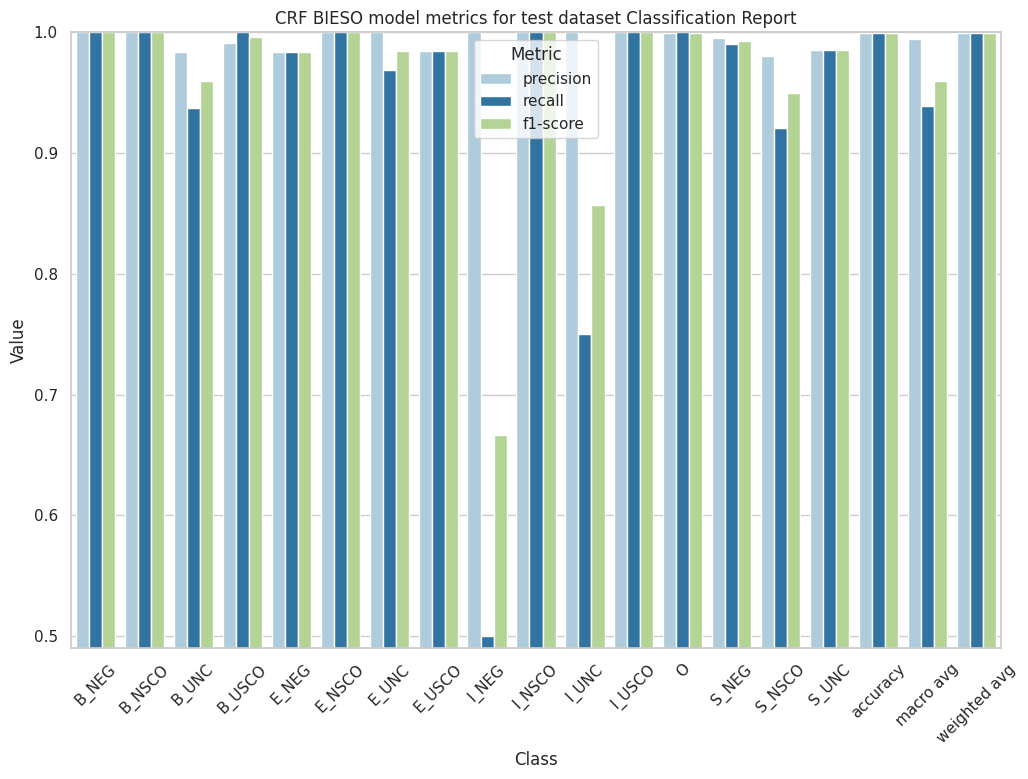

In [ ]:
# Evaluate on test data
y_pred_crf_bieso = crf_bieso.predict(X_test_bieso)
report_crf_bieso = evaluate(flatten(y_test_bieso),flatten(y_pred_crf_bieso),dataset="test",model='CRF BIESO')

### HMM

In [ ]:
y_pred_test_hmm = [tag for word,tag in tagged_seq]
y_test_hmm = [tag for word,tag in test_run_base]


HMM model evaluation for test dataset:
+--------------+-------------+----------+------------+-------------+
|              |   precision |   recall |   f1-score |     support |
+==============+=============+==========+============+=============+
| .            |   1         | 1        |   1        |  208        |
+--------------+-------------+----------+------------+-------------+
| NEG          |   0.982143  | 0.932203 |   0.956522 |  118        |
+--------------+-------------+----------+------------+-------------+
| NSCO         |   0.761765  | 0.759531 |   0.760646 |  341        |
+--------------+-------------+----------+------------+-------------+
| O            |   0.979366  | 0.886609 |   0.930682 | 3801        |
+--------------+-------------+----------+------------+-------------+
| UNC          |   0.5       | 0.571429 |   0.533333 |    7        |
+--------------+-------------+----------+------------+-------------+
| USCO         |   0.0234987 | 0.529412 |   0.045    |   17    

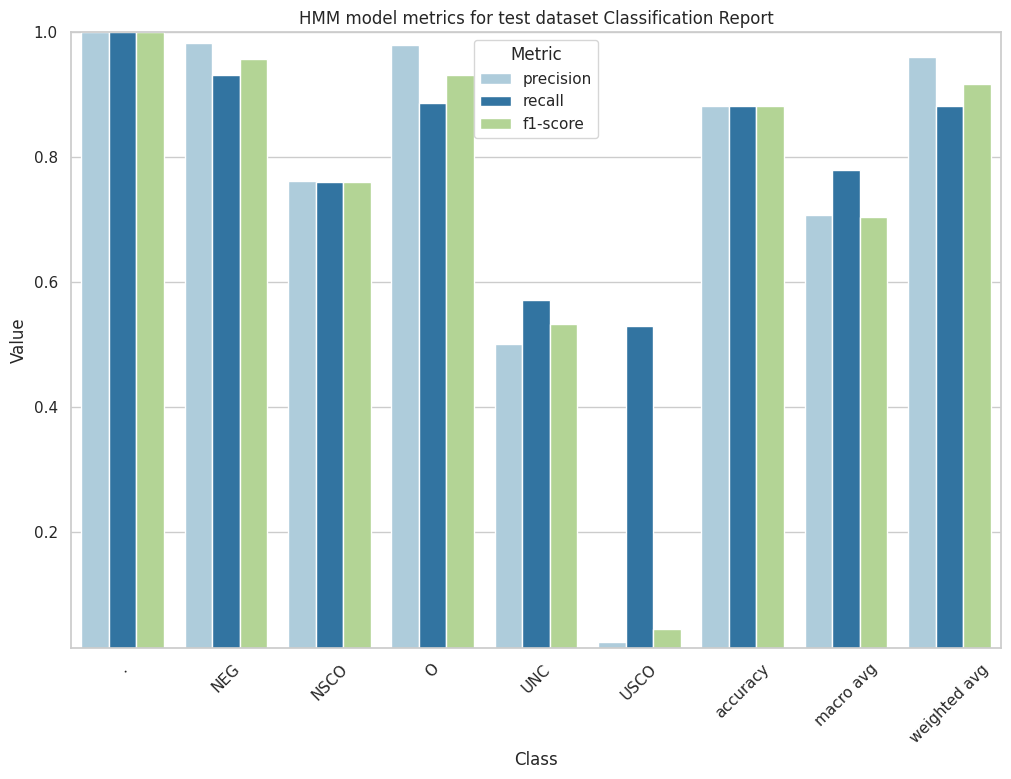

In [ ]:
report_hmm = evaluate(y_test_hmm,y_pred_test_hmm,dataset="test",model='HMM')

In [ ]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [ ]:
incorrect_tagged_cases[:20]

[[(':', 'O'), (('27.06.1959', 'USCO'), ('27.06.1959', 'O'))],
 [('12.07.2018', 'O'), (('10:24:42', 'USCO'), ('10:24:42', 'O'))],
 [('del', 'O'), (('tendon', 'USCO'), ('tendon', 'O'))],
 [('tendon', 'O'), (('de', 'USCO'), ('de', 'O'))],
 [('de', 'O'), (('aquiles', 'USCO'), ('aquiles', 'O'))],
 [('aquiles', 'O'), (('en', 'USCO'), ('en', 'O'))],
 [('con', 'O'), (('fibratos', 'USCO'), ('fibratos', 'O'))],
 [('controles', 'O'), (('bianuales', 'USCO'), ('bianuales', 'O'))],
 [('bianuales', 'O'), (('por', 'USCO'), ('por', 'O'))],
 [('ausencia', 'NEG'), (('de', 'NSCO'), ('de', 'NEG'))],
 [('de', 'NEG'), (('cola', 'O'), ('cola', 'NSCO'))],
 [('7.', 'O'), (('turbeculosis', 'USCO'), ('turbeculosis', 'O'))],
 [('turbeculosis', 'O'), (('pulmonar', 'USCO'), ('pulmonar', 'O'))],
 [('pulmonar', 'O'), (('en', 'USCO'), ('en', 'O'))],
 [('en', 'O'), (('la', 'USCO'), ('la', 'O'))],
 [('la', 'O'), (('infancai', 'USCO'), ('infancai', 'O'))],
 [('fenotipo', 'O'), (('agudizados', 'USCO'), ('agudizados', 'O'))

### SVM Baseline


SVM Baseline model evaluation for test dataset:
+--------------+-------------+----------+------------+-------------+
|              |   precision |   recall |   f1-score |     support |
+==============+=============+==========+============+=============+
| NEG          |    0.976864 | 0.966102 |   0.971453 |  1180       |
+--------------+-------------+----------+------------+-------------+
| NSCO         |    0.957564 | 0.929132 |   0.943133 |  3570       |
+--------------+-------------+----------+------------+-------------+
| O            |    0.994803 | 0.99666  |   0.995731 | 58388       |
+--------------+-------------+----------+------------+-------------+
| UNC          |    0.968586 | 0.925    |   0.946292 |   200       |
+--------------+-------------+----------+------------+-------------+
| USCO         |    0.943686 | 0.975309 |   0.959237 |   567       |
+--------------+-------------+----------+------------+-------------+
| accuracy     |    0.99191  | 0.99191  |   0.99191  |

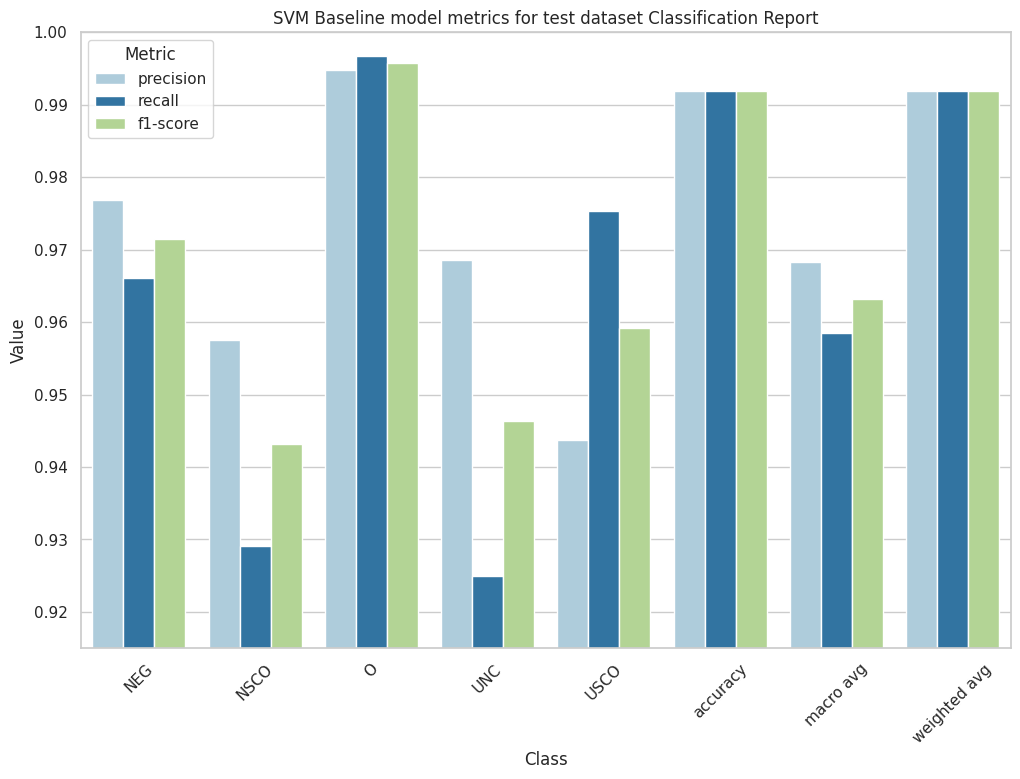

In [ ]:
y_test_svm, y_pred_svm = train_svm(X_train, y_train, X_test, y_test)
report_svm_baseline = evaluate(y_test_svm, y_pred_svm, dataset='test', model="SVM Baseline")

### SVM BIO Tagging


SVM BIO model evaluation for test dataset:
+--------------+-------------+----------+------------+--------------+
|              |   precision |   recall |   f1-score |      support |
+==============+=============+==========+============+==============+
| B_NEG        |    0.993699 | 0.989247 |   0.991468 |  1116        |
+--------------+-------------+----------+------------+--------------+
| B_NSCO       |    0.993321 | 0.977465 |   0.985329 |  1065        |
+--------------+-------------+----------+------------+--------------+
| B_UNC        |    1        | 0.992424 |   0.996198 |   132        |
+--------------+-------------+----------+------------+--------------+
| B_USCO       |    0.962121 | 0.984496 |   0.97318  |   129        |
+--------------+-------------+----------+------------+--------------+
| I_NEG        |    0.686567 | 0.71875  |   0.70229  |    64        |
+--------------+-------------+----------+------------+--------------+
| I_NSCO       |    0.950393 | 0.917764 |   0.

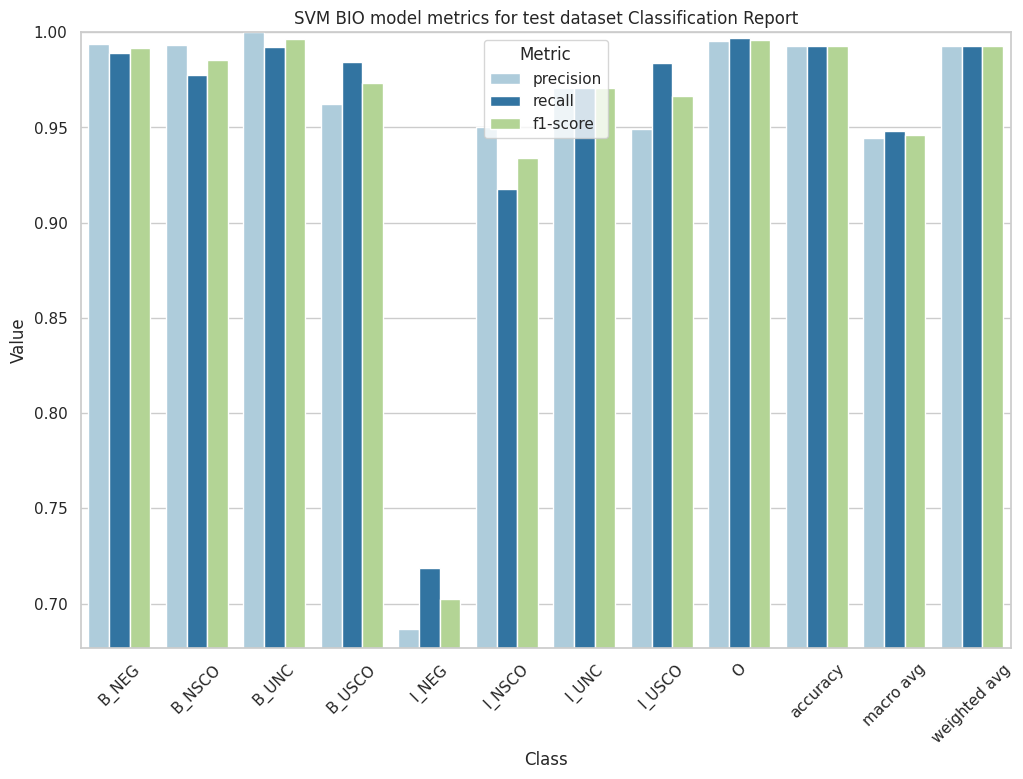

In [ ]:
y_test_bio_svm, y_pred_bio_svm = train_svm(X_train_bio, y_train_bio, X_test_bio, y_test_bio)
report_svm_bio = evaluate(y_test_bio_svm, y_pred_bio_svm, dataset='test', model="SVM BIO")

### SVM BIESO Tagging


SVM BIESO model evaluation for test dataset:
+--------------+-------------+----------+------------+--------------+
|              |   precision |   recall |   f1-score |      support |
+==============+=============+==========+============+==============+
| B_NEG        |    1        | 1        |   1        |    62        |
+--------------+-------------+----------+------------+--------------+
| B_NSCO       |    0.997472 | 1        |   0.998734 |   789        |
+--------------+-------------+----------+------------+--------------+
| B_UNC        |    0.984615 | 1        |   0.992248 |    64        |
+--------------+-------------+----------+------------+--------------+
| B_USCO       |    1        | 1        |   1        |   115        |
+--------------+-------------+----------+------------+--------------+
| E_NEG        |    1        | 1        |   1        |    62        |
+--------------+-------------+----------+------------+--------------+
| E_NSCO       |    1        | 1        |   

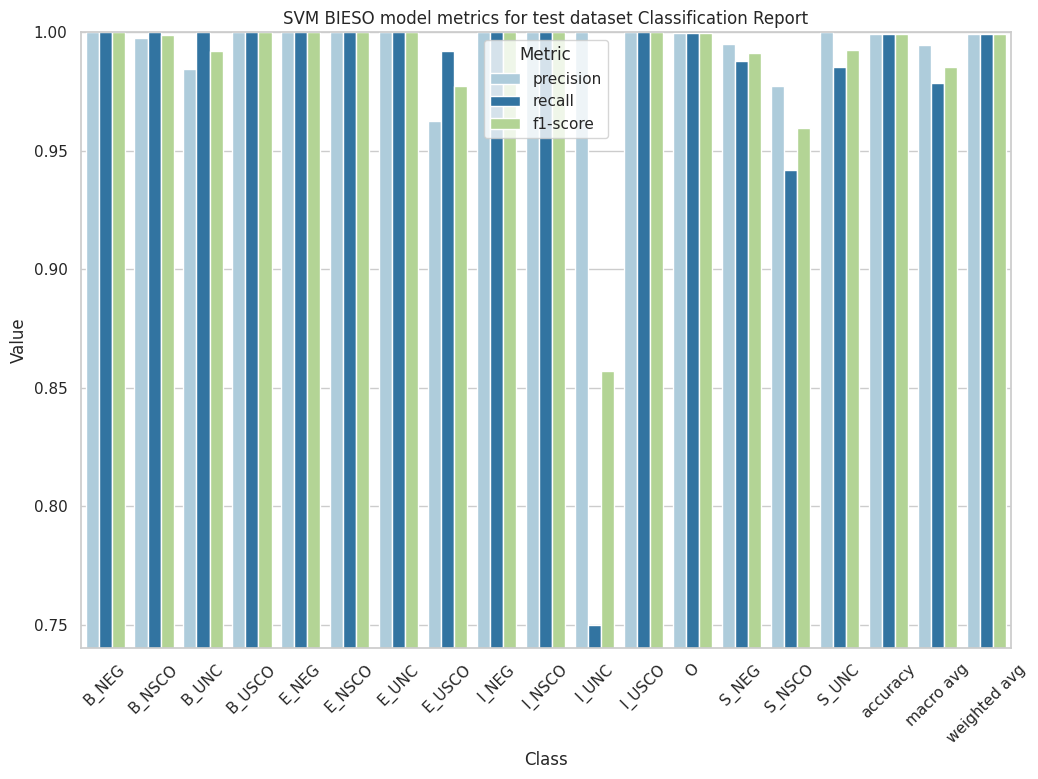

In [ ]:
y_test_bieso_svm, y_pred_bieso_svm = train_svm(X_train_bieso, y_train_bieso, X_test_bieso, y_test_bieso)
report_svm_bieso = evaluate(y_test_bieso_svm, y_pred_bieso_svm, dataset='test', model="SVM BIESO")

### MULTINOMIAL_NB Baseline


NB Baseline (dict vector) model evaluation for test dataset:
+--------------+-------------+----------+------------+--------------+
|              |   precision |   recall |   f1-score |      support |
+==============+=============+==========+============+==============+
| NEG          |    0.908939 | 0.922034 |   0.91544  |  1180        |
+--------------+-------------+----------+------------+--------------+
| NSCO         |    0.752289 | 0.87451  |   0.808808 |  3570        |
+--------------+-------------+----------+------------+--------------+
| O            |    0.988333 | 0.982222 |   0.985268 | 58388        |
+--------------+-------------+----------+------------+--------------+
| UNC          |    0.947761 | 0.635    |   0.760479 |   200        |
+--------------+-------------+----------+------------+--------------+
| USCO         |    0.919395 | 0.643739 |   0.757261 |   567        |
+--------------+-------------+----------+------------+--------------+
| accuracy     |    0.971004

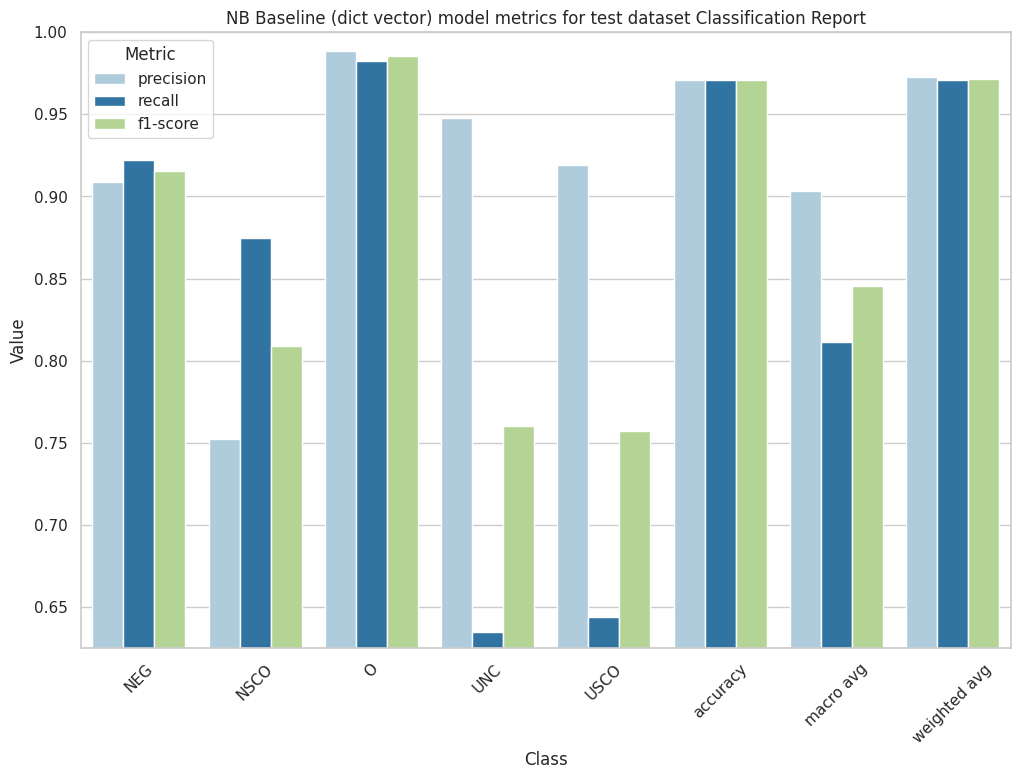

In [26]:
y_test_nb, y_pred_nb = train_mnb_with_dict_vector(X_train, y_train, X_test, y_test)
report_nb_baseline = evaluate(y_test_nb, y_pred_nb, dataset='test',model="NB Baseline (dict vector)")


NB Baseline (tfidf vector) model evaluation for test dataset:
+--------------+-------------+-----------+------------+--------------+
|              |   precision |    recall |   f1-score |      support |
+==============+=============+===========+============+==============+
| NEG          |    0.957721 | 0.883051  |  0.918871  |  1180        |
+--------------+-------------+-----------+------------+--------------+
| NSCO         |    0.881532 | 0.548179  |  0.675993  |  3570        |
+--------------+-------------+-----------+------------+--------------+
| O            |    0.959245 | 0.995273  |  0.976927  | 58388        |
+--------------+-------------+-----------+------------+--------------+
| UNC          |    1        | 0         |  0         |   200        |
+--------------+-------------+-----------+------------+--------------+
| USCO         |    0.875    | 0.0246914 |  0.0480274 |   567        |
+--------------+-------------+-----------+------------+--------------+
| accuracy    

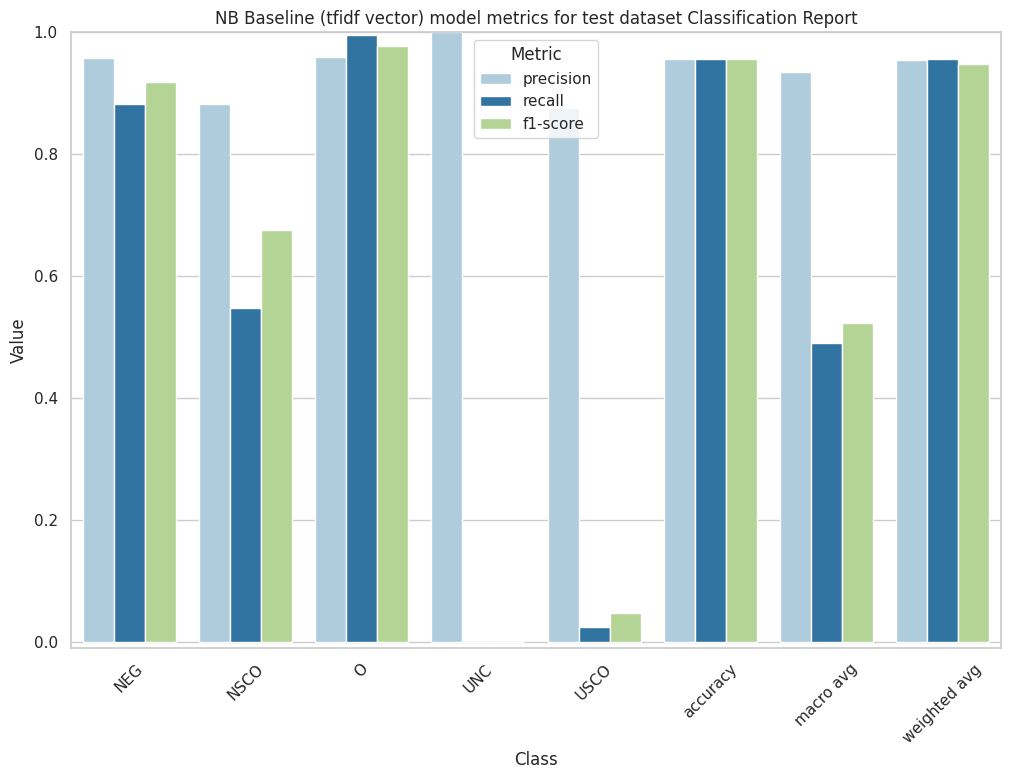

In [27]:
y_test_nb2, y_pred_nb2 = train_mnb_with_tfidf_vector(X_train, y_train, X_test, y_test)
report_nb_baseline2 = evaluate(y_test_nb2, y_pred_nb2, dataset='test',model="NB Baseline (tfidf vector)")

### MULTINOMIAL_NB BIO Tagging


NB BIO (dict vector) model evaluation for test dataset:
+--------------+-------------+----------+------------+-------------+
|              |   precision |   recall |   f1-score |     support |
+==============+=============+==========+============+=============+
| B_NEG        |    0.919696 | 0.97491  |   0.946498 |  1116       |
+--------------+-------------+----------+------------+-------------+
| B_NSCO       |    0.753569 | 0.941784 |   0.837229 |  1065       |
+--------------+-------------+----------+------------+-------------+
| B_UNC        |    0.942857 | 0.75     |   0.835443 |   132       |
+--------------+-------------+----------+------------+-------------+
| B_USCO       |    0.970149 | 0.503876 |   0.663265 |   129       |
+--------------+-------------+----------+------------+-------------+
| I_NEG        |    1        | 0        |   0        |    64       |
+--------------+-------------+----------+------------+-------------+
| I_NSCO       |    0.824529 | 0.891018 |   0.

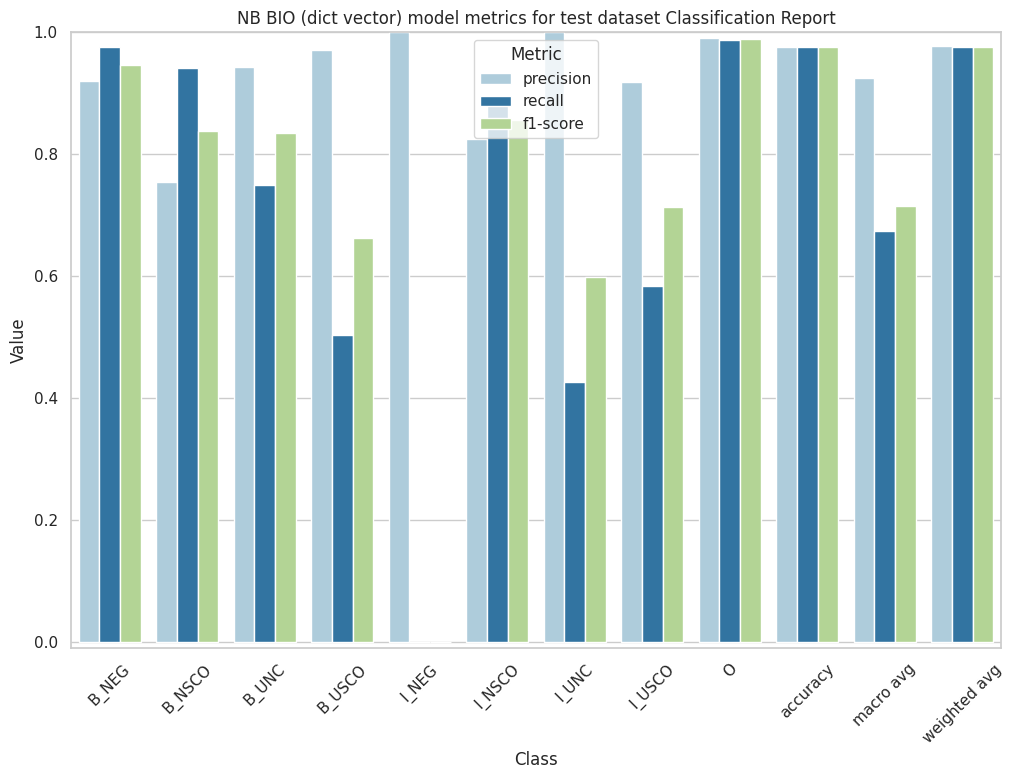

In [ ]:
y_test_nb_bio, y_pred_nb_bio = train_mnb_with_dict_vector(X_train_bio, y_train_bio, X_test_bio, y_test_bio)
report_nb_bio = evaluate(y_test_nb_bio, y_pred_nb_bio, dataset='test',model="NB BIO (dict vector)")


NB BIO (tfidf vector) model evaluation for test dataset:
+--------------+-------------+------------+------------+--------------+
|              |   precision |     recall |   f1-score |      support |
+==============+=============+============+============+==============+
| B_NEG        |    0.958182 | 0.944444   | 0.951264   |  1116        |
+--------------+-------------+------------+------------+--------------+
| B_NSCO       |    0.959283 | 0.553052   | 0.701608   |  1065        |
+--------------+-------------+------------+------------+--------------+
| B_UNC        |    1        | 0.00757576 | 0.0150376  |   132        |
+--------------+-------------+------------+------------+--------------+
| B_USCO       |    1        | 0          | 0          |   129        |
+--------------+-------------+------------+------------+--------------+
| I_NEG        |    1        | 0          | 0          |    64        |
+--------------+-------------+------------+------------+--------------+
| I_NS

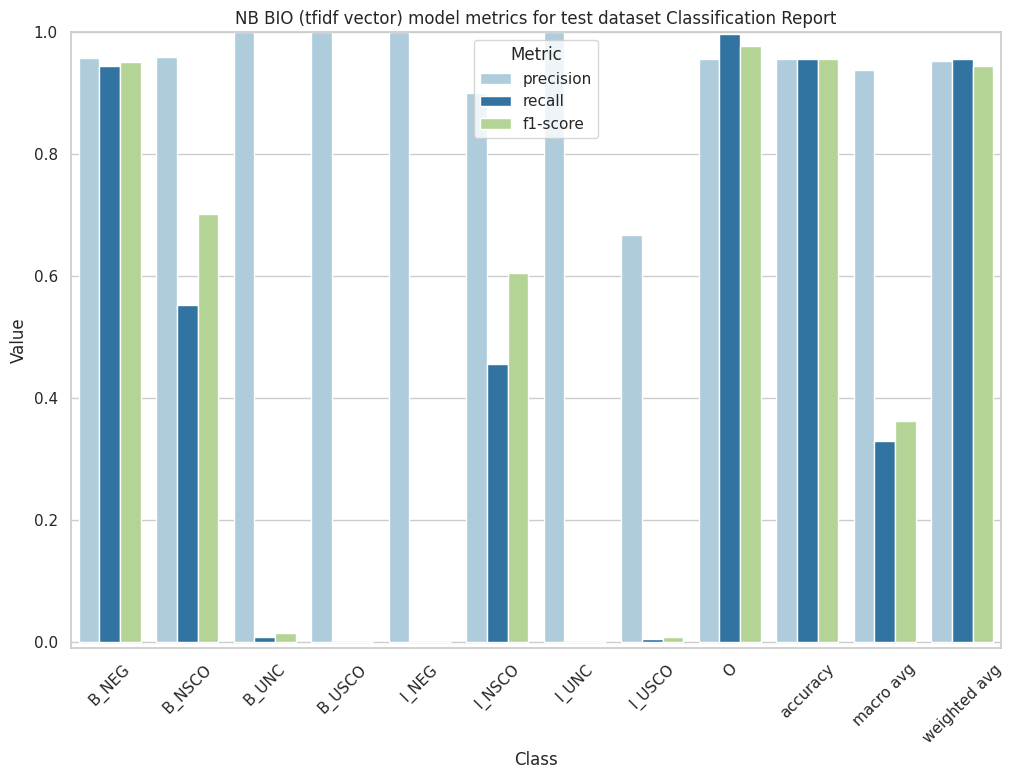

In [ ]:
y_test_nb_bio2, y_pred_nb_bio2 = train_mnb_with_tfidf_vector(X_train_bio, y_train_bio, X_test_bio, y_test_bio)
report_nb_bio2 = evaluate(y_test_nb_bio2, y_pred_nb_bio2, dataset='test',model="NB BIO (tfidf vector)")

### MULTINOMIAL_NB BIESO Tagging


NB BIESO (dict_vector) model evaluation for test dataset:
+--------------+-------------+------------+------------+--------------+
|              |   precision |     recall |   f1-score |      support |
+==============+=============+============+============+==============+
| B_NEG        |    1        | 0.274194   |  0.43038   |    62        |
+--------------+-------------+------------+------------+--------------+
| B_NSCO       |    0.860068 | 0.958175   |  0.906475  |   789        |
+--------------+-------------+------------+------------+--------------+
| B_UNC        |    0.954545 | 0.65625    |  0.777778  |    64        |
+--------------+-------------+------------+------------+--------------+
| B_USCO       |    0.984375 | 0.547826   |  0.703911  |   115        |
+--------------+-------------+------------+------------+--------------+
| E_NEG        |    1        | 0          |  0         |    62        |
+--------------+-------------+------------+------------+--------------+
| E_N

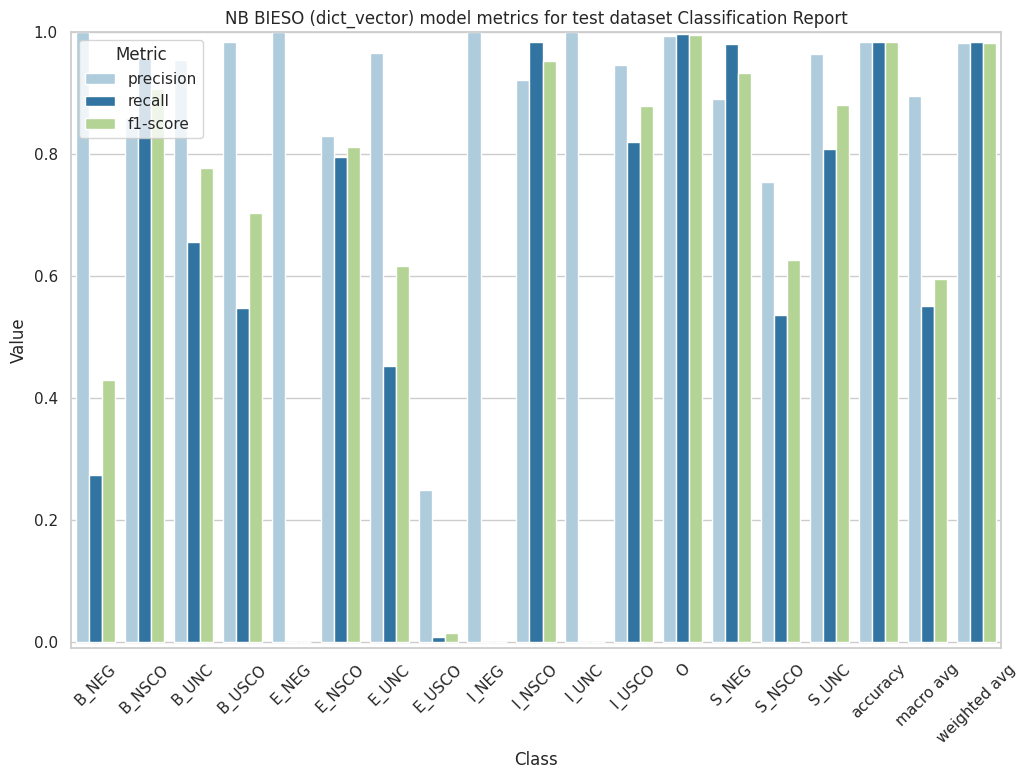

In [ ]:
y_test_nb_bieso, y_pred_nb_bieso = train_mnb_with_dict_vector(X_train_bieso, y_train_bieso, X_test_bieso, y_test_bieso)
report_nb_bieso = evaluate(y_test_nb_bieso, y_pred_nb_bieso, dataset='test',model="NB BIESO (dict_vector)")


NB BIESO (tfidf vector) model evaluation for test dataset:
+--------------+-------------+-----------+------------+--------------+
|              |   precision |    recall |   f1-score |      support |
+==============+=============+===========+============+==============+
| B_NEG        |    1        | 0         |  0         |    62        |
+--------------+-------------+-----------+------------+--------------+
| B_NSCO       |    0.850575 | 0.562738  |  0.677346  |   789        |
+--------------+-------------+-----------+------------+--------------+
| B_UNC        |    1        | 0         |  0         |    64        |
+--------------+-------------+-----------+------------+--------------+
| B_USCO       |    1        | 0         |  0         |   115        |
+--------------+-------------+-----------+------------+--------------+
| E_NEG        |    1        | 0         |  0         |    62        |
+--------------+-------------+-----------+------------+--------------+
| E_NSCO       | 

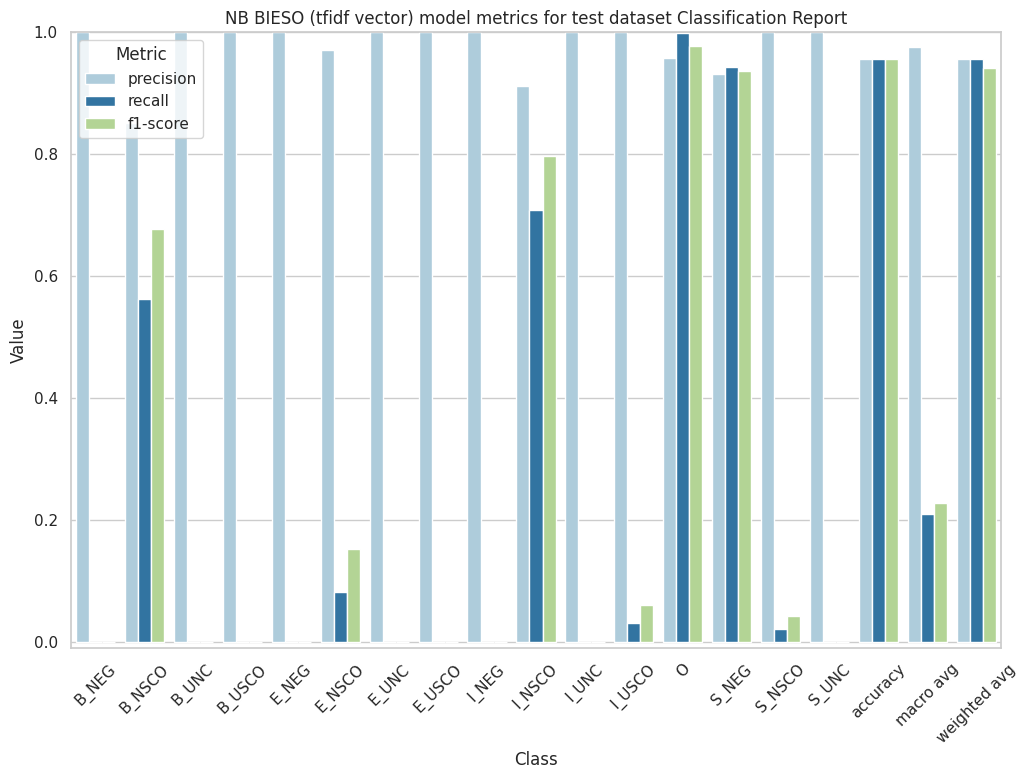

In [ ]:
y_test_nb_bieso2, y_pred_nb_bieso2 = train_mnb_with_tfidf_vector(X_train_bieso, y_train_bieso, X_test_bieso, y_test_bieso)
report_nb_bieso2 = evaluate(y_test_nb_bieso2, y_pred_nb_bieso2, dataset='test',model="NB BIESO (tfidf vector)")

### LOGISTIC REGRESSION Baseline

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



LR Baseline (dict vector) model evaluation for test dataset:
+--------------+-------------+----------+------------+--------------+
|              |   precision |   recall |   f1-score |      support |
+==============+=============+==========+============+==============+
| NEG          |    0.981818 | 0.961017 |   0.971306 |  1180        |
+--------------+-------------+----------+------------+--------------+
| NSCO         |    0.963525 | 0.92493  |   0.943833 |  3570        |
+--------------+-------------+----------+------------+--------------+
| O            |    0.994483 | 0.997106 |   0.995792 | 58388        |
+--------------+-------------+----------+------------+--------------+
| UNC          |    0.97861  | 0.915    |   0.945736 |   200        |
+--------------+-------------+----------+------------+--------------+
| USCO         |    0.939394 | 0.984127 |   0.96124  |   567        |
+--------------+-------------+----------+------------+--------------+
| accuracy     |    0.992035

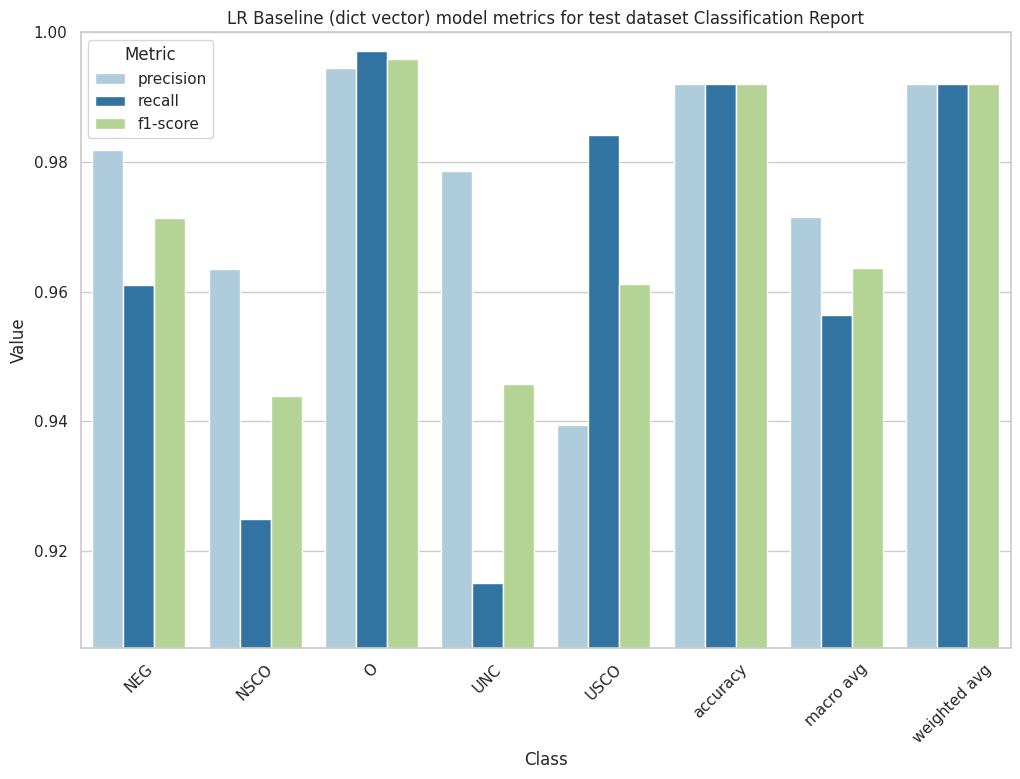

In [ ]:
y_test_lr, y_pred_lr = train_lr_with_dict_vector(X_train, y_train, X_test, y_test)#1min
report_lr = evaluate(y_test_lr, y_pred_lr, dataset='test',model="LR Baseline (dict vector)")


LR Baseline (tfidf vector) model evaluation for test dataset:
+--------------+-------------+----------+------------+--------------+
|              |   precision |   recall |   f1-score |      support |
+==============+=============+==========+============+==============+
| NEG          |    0.964594 | 0.94661  |   0.955518 |  1180        |
+--------------+-------------+----------+------------+--------------+
| NSCO         |    0.955381 | 0.917647 |   0.936134 |  3570        |
+--------------+-------------+----------+------------+--------------+
| O            |    0.993341 | 0.996318 |   0.994827 | 58388        |
+--------------+-------------+----------+------------+--------------+
| UNC          |    0.988304 | 0.845    |   0.911051 |   200        |
+--------------+-------------+----------+------------+--------------+
| USCO         |    0.916096 | 0.943563 |   0.929626 |   567        |
+--------------+-------------+----------+------------+--------------+
| accuracy     |    0.99006

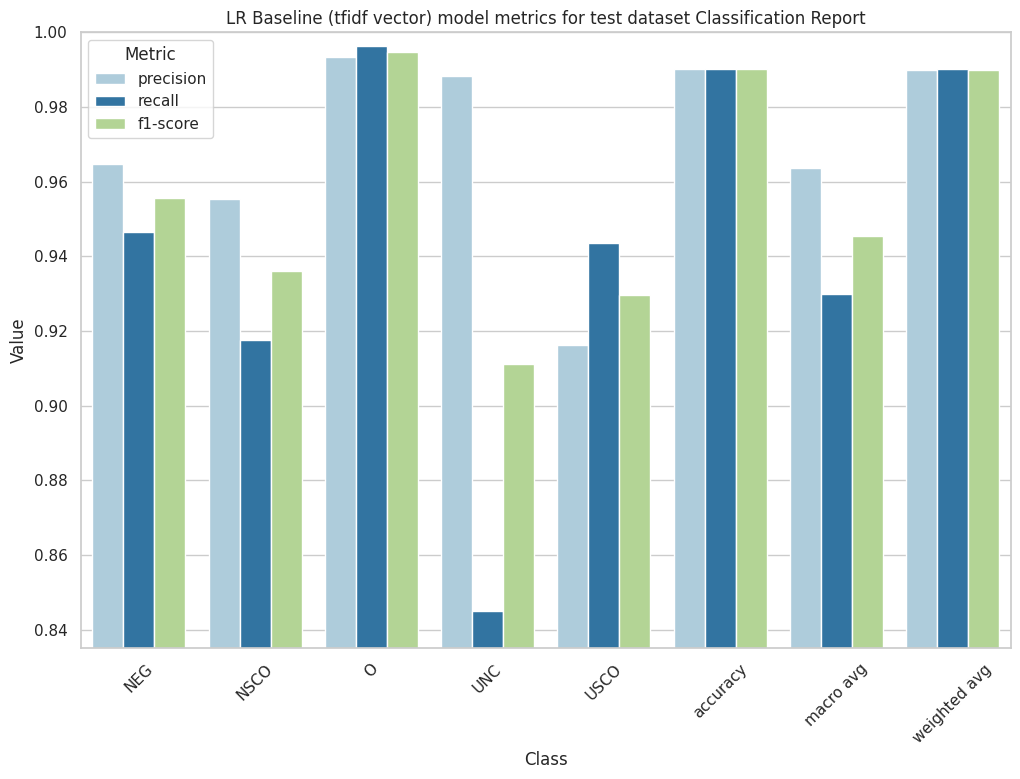

In [ ]:
y_test_lr2, y_pred_lr2 = train_lr_with_tfidf_vector(X_train, y_train, X_test, y_test)#3 min
report_lr2 = evaluate(y_test_lr2, y_pred_lr2, dataset='test',model="LR Baseline (tfidf vector)")

### LOGISTIC REGRESSION BIO Tagging

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



LR BIO (dict vector) model evaluation for test dataset:
+--------------+-------------+----------+------------+--------------+
|              |   precision |   recall |   f1-score |      support |
+==============+=============+==========+============+==============+
| B_NEG        |    0.994595 | 0.989247 |   0.991914 |  1116        |
+--------------+-------------+----------+------------+--------------+
| B_NSCO       |    0.992366 | 0.976526 |   0.984382 |  1065        |
+--------------+-------------+----------+------------+--------------+
| B_UNC        |    0.992366 | 0.984848 |   0.988593 |   132        |
+--------------+-------------+----------+------------+--------------+
| B_USCO       |    1        | 0.976744 |   0.988235 |   129        |
+--------------+-------------+----------+------------+--------------+
| I_NEG        |    0.650794 | 0.640625 |   0.645669 |    64        |
+--------------+-------------+----------+------------+--------------+
| I_NSCO       |    0.961296 | 0.

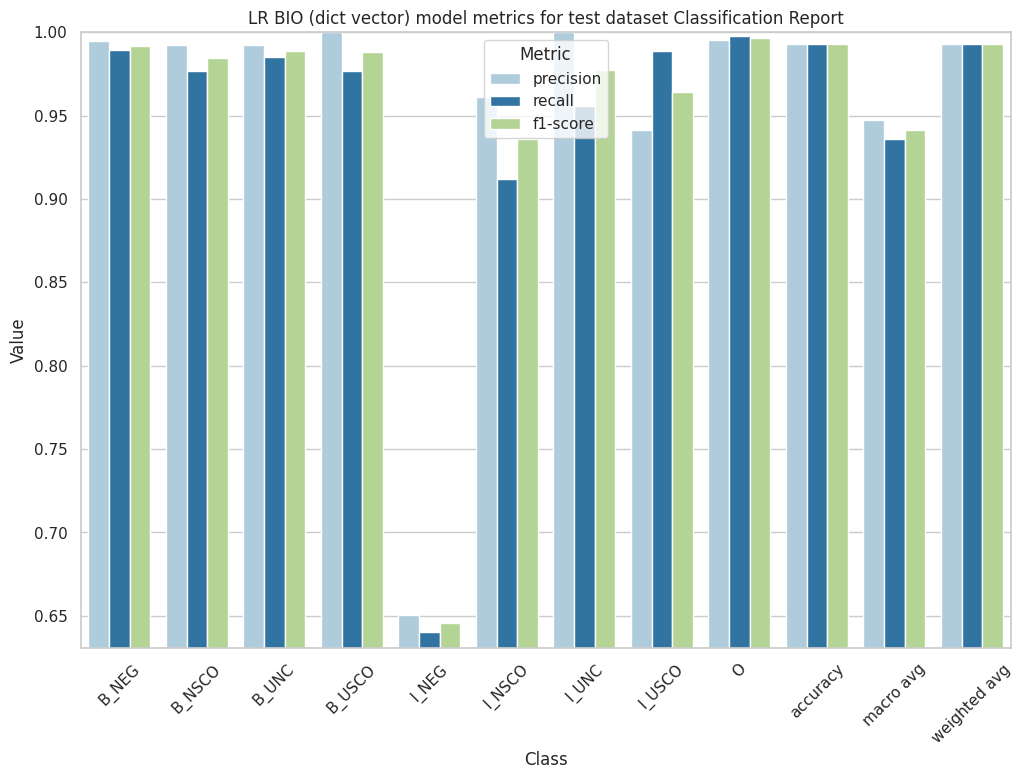

In [ ]:
y_test_lr_bio, y_pred_lr_bio = train_lr_with_dict_vector(X_train_bio, y_train_bio, X_test_bio, y_test_bio)#1 min
report_lr_bio = evaluate(y_test_lr_bio, y_pred_lr_bio, dataset='test',model="LR BIO (dict vector)")


LR BIO (tfidf vector) model evaluation for test dataset:
+--------------+-------------+----------+------------+--------------+
|              |   precision |   recall |   f1-score |      support |
+==============+=============+==========+============+==============+
| B_NEG        |    0.984685 | 0.979391 |   0.982031 |  1116        |
+--------------+-------------+----------+------------+--------------+
| B_NSCO       |    0.991098 | 0.940845 |   0.965318 |  1065        |
+--------------+-------------+----------+------------+--------------+
| B_UNC        |    0.959677 | 0.901515 |   0.929688 |   132        |
+--------------+-------------+----------+------------+--------------+
| B_USCO       |    1        | 0.906977 |   0.95122  |   129        |
+--------------+-------------+----------+------------+--------------+
| I_NEG        |    0.673469 | 0.515625 |   0.584071 |    64        |
+--------------+-------------+----------+------------+--------------+
| I_NSCO       |    0.949854 | 0

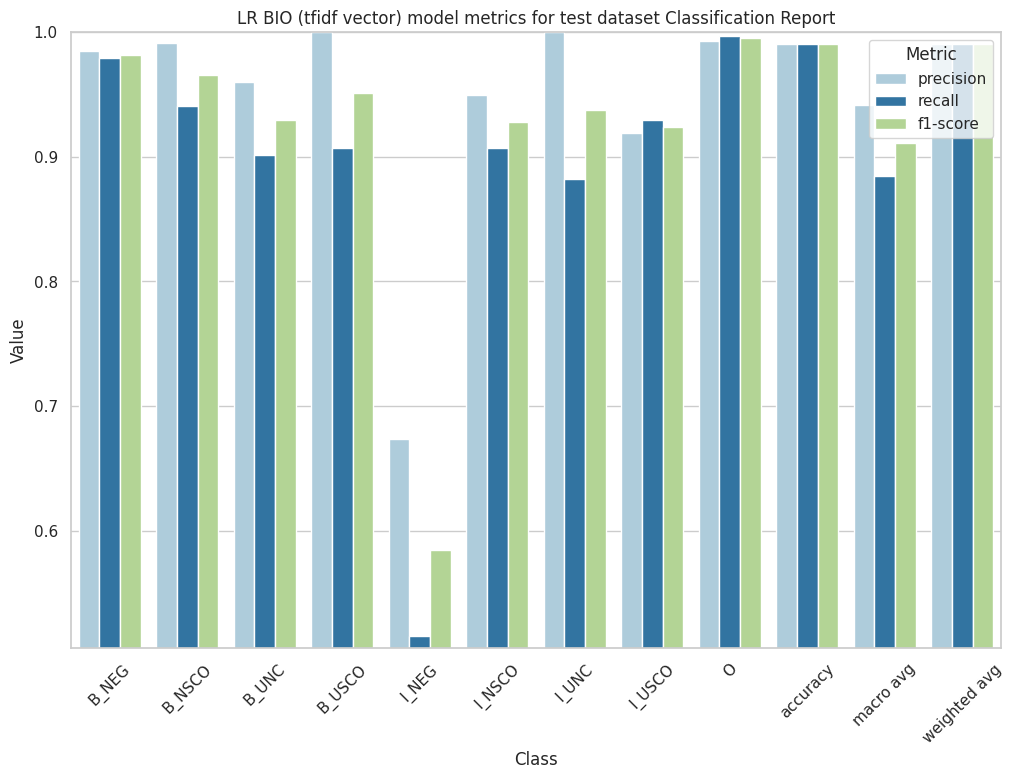

In [ ]:
y_test_lr_bio2, y_pred_lr_bio2 = train_lr_with_tfidf_vector(X_train_bio, y_train_bio, X_test_bio, y_test_bio)#5min
report_lr_bio2 = evaluate(y_test_lr_bio2, y_pred_lr_bio2, dataset='test',model="LR BIO (tfidf vector)")

### LOGISTIC REGRESSION BIESO Tagging




LR BIESO (dict vector) model evaluation for test dataset:
+--------------+-------------+----------+------------+--------------+
|              |   precision |   recall |   f1-score |      support |
+==============+=============+==========+============+==============+
| B_NEG        |    1        | 0.983871 |   0.99187  |    62        |
+--------------+-------------+----------+------------+--------------+
| B_NSCO       |    1        | 0.998733 |   0.999366 |   789        |
+--------------+-------------+----------+------------+--------------+
| B_UNC        |    0.983607 | 0.9375   |   0.96     |    64        |
+--------------+-------------+----------+------------+--------------+
| B_USCO       |    0.982906 | 1        |   0.991379 |   115        |
+--------------+-------------+----------+------------+--------------+
| E_NEG        |    0.983607 | 0.967742 |   0.97561  |    62        |
+--------------+-------------+----------+------------+--------------+
| E_NSCO       |    1        | 

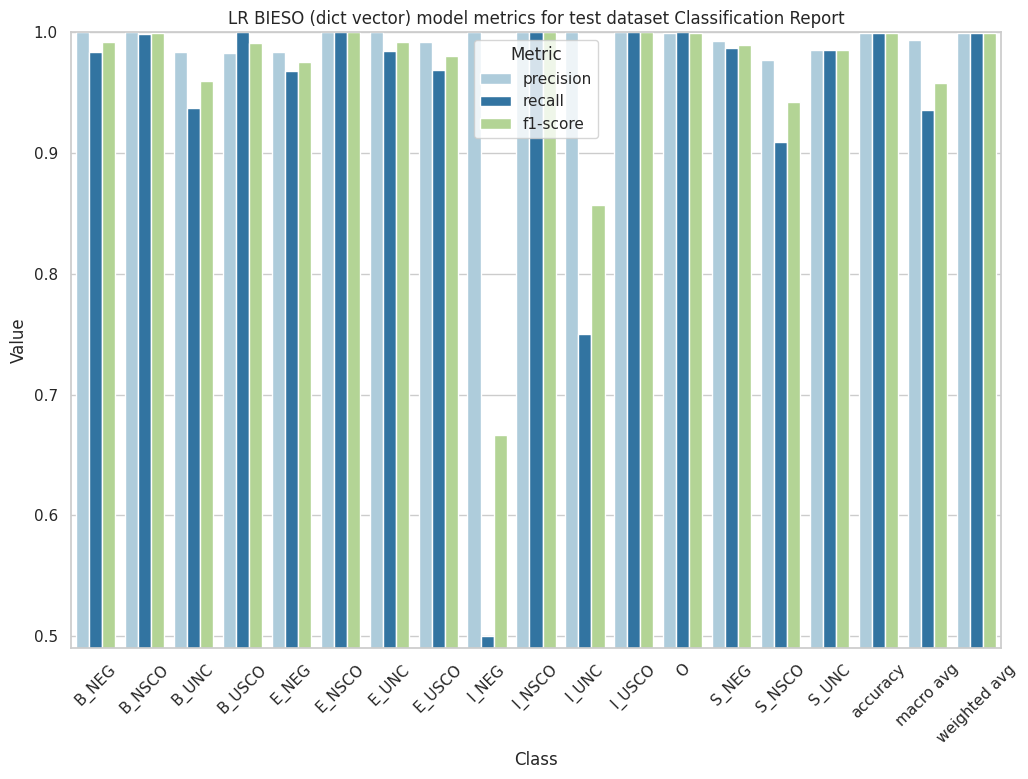

In [ ]:
y_test_lr_bieso, y_pred_lr_bieso = train_lr_with_dict_vector(X_train_bieso, y_train_bieso, X_test_bieso, y_test_bieso)#2min
report_lr_bieso = evaluate(y_test_lr_bieso, y_pred_lr_bieso, dataset='test',model="LR BIESO (dict vector)")


LR BIESO (tfidf vector) model evaluation for test dataset:
+--------------+-------------+----------+------------+--------------+
|              |   precision |   recall |   f1-score |      support |
+==============+=============+==========+============+==============+
| B_NEG        |    1        | 0.935484 |   0.966667 |    62        |
+--------------+-------------+----------+------------+--------------+
| B_NSCO       |    1        | 0.975919 |   0.987813 |   789        |
+--------------+-------------+----------+------------+--------------+
| B_UNC        |    0.931034 | 0.84375  |   0.885246 |    64        |
+--------------+-------------+----------+------------+--------------+
| B_USCO       |    0.991304 | 0.991304 |   0.991304 |   115        |
+--------------+-------------+----------+------------+--------------+
| E_NEG        |    0.967213 | 0.951613 |   0.95935  |    62        |
+--------------+-------------+----------+------------+--------------+
| E_NSCO       |    1        |

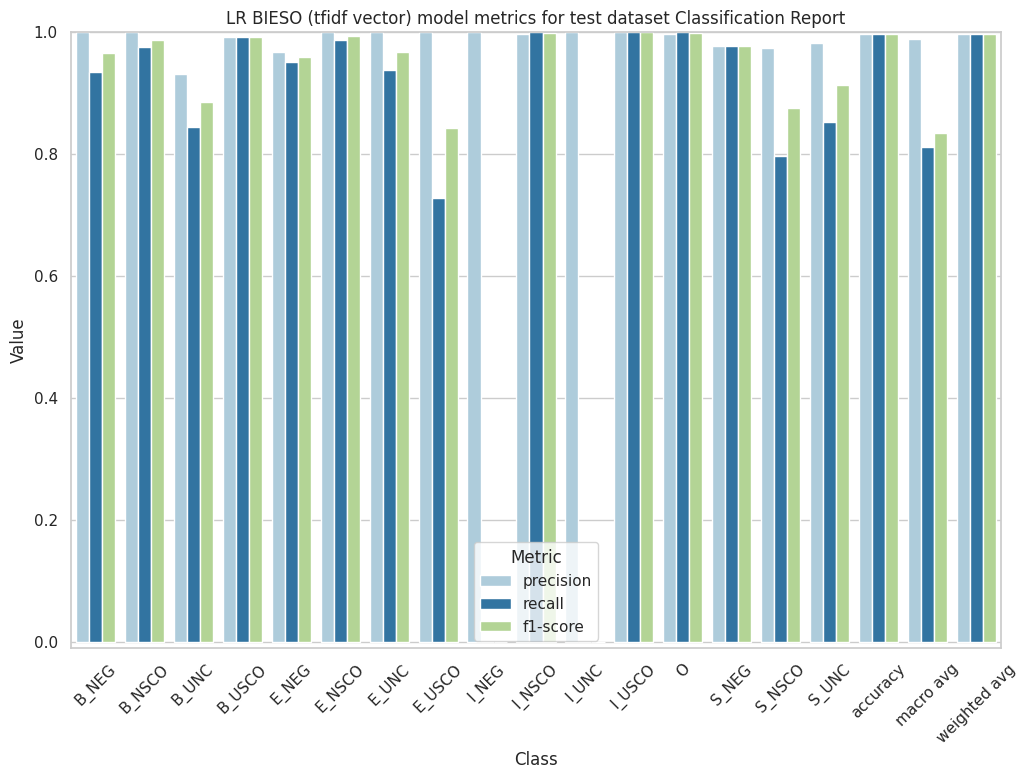

In [ ]:
y_test_lr_bieso2, y_pred_lr_bieso2 = train_lr_with_tfidf_vector(X_train_bieso, y_train_bieso, X_test_bieso, y_test_bieso)#7min
report_lr_bieso2 = evaluate(y_test_lr_bieso2, y_pred_lr_bieso2, dataset='test',model="LR BIESO (tfidf vector)")

## Model comparisons

In [ ]:
def plot_comparisons(reports,names):
    accuracies, precisions, recalls, f1_scores = [],[],[],[]
    for report in reports:
        accuracies.append(report.loc['accuracy','support'])
        precisions.append(report.loc['macro avg','precision'])
        recalls.append(report.loc['macro avg','recall'])
        f1_scores.append(report.loc['macro avg','f1-score'])

    data = {
        'Model': names,
        'Accuracy': accuracies,
        'Precision': precisions,
        'Recall': recalls,
        'F1-score': f1_scores
    }
    df = pd.DataFrame(data)

    df['Set'] = 'Test'

    # Melt DataFrame to long format for Seaborn plot
    df = pd.melt(df, id_vars=['Model', 'Set'], var_name='Metric', value_name='Value')

    # Plot
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x='Model', y='Value', hue='Metric', data=df, hue_order=['Accuracy', 'Precision', 'Recall', 'F1-Score'], palette='Paired')
    plt.title('Metrics of Models on Test Sets')
    plt.xlabel('Model')
    plt.ylabel('Value')
    plt.ylim(0.5, 1)
    plt.legend(title='Metric', loc='upper left')
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')
    plt.show()


names = ["CRF","HMM","SVM","MultiNB","MultiNB 2","LR", "LR2"]

### Baseline models

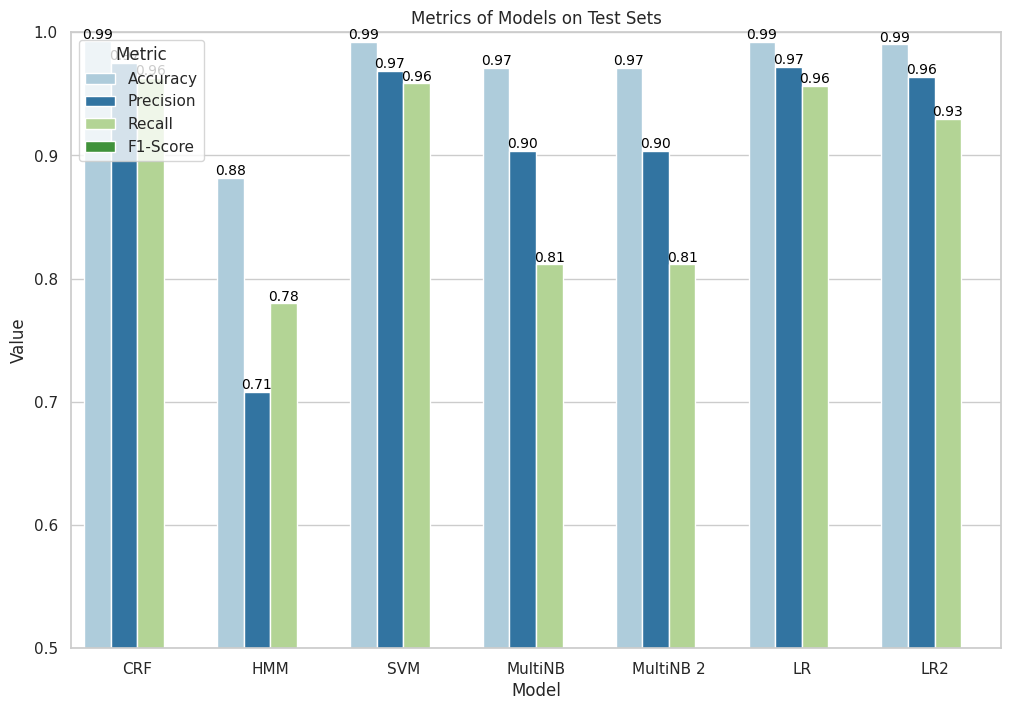

In [ ]:
reports_baseline = [report_crf, report_hmm, report_svm_baseline, report_nb_baseline, report_nb_baseline2, report_lr, report_lr2]
plot_comparisons(reports_baseline,names)

### BIO models

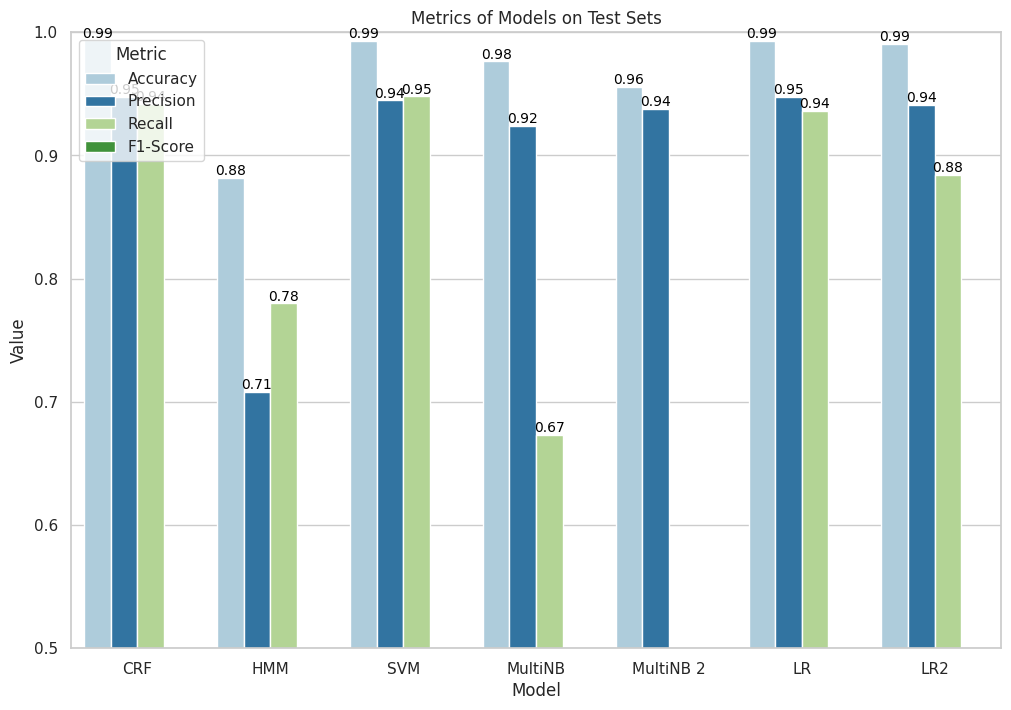

In [ ]:
reports_bio = [report_crf_bio, report_hmm, report_svm_bio, report_nb_bio, report_nb_bio2, report_lr_bio, report_lr_bio2]
plot_comparisons(reports_bio,names)

### BIESO models

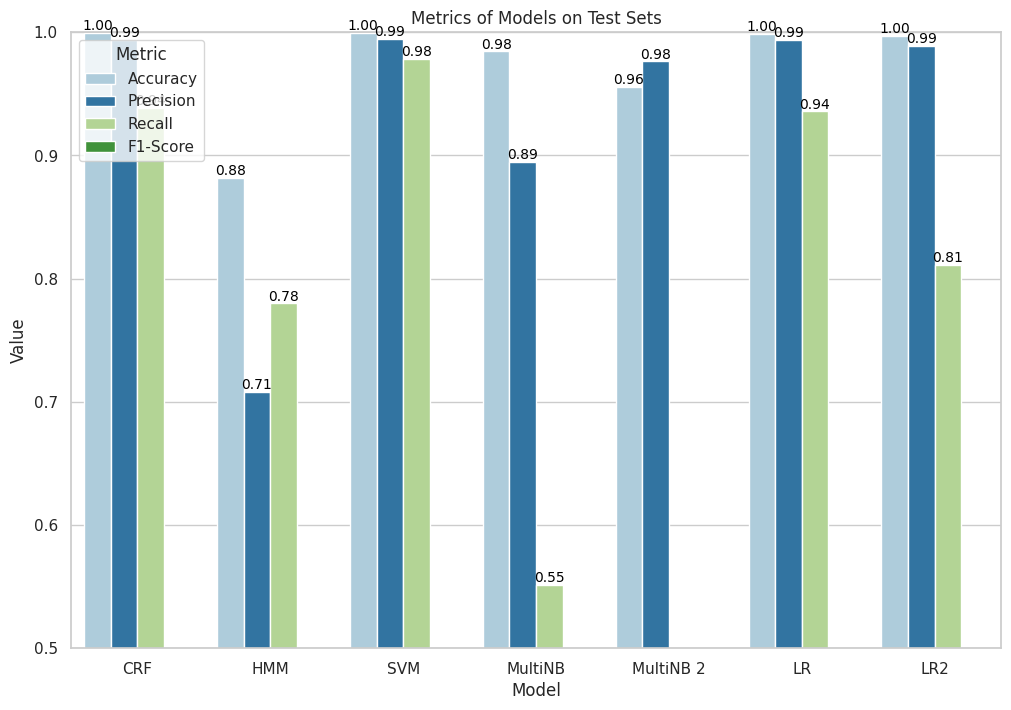

In [ ]:
reports_bieso = [report_crf_bieso, report_hmm, report_svm_bieso, report_nb_bieso, report_nb_bieso2, report_lr_bieso, report_lr_bieso2]
plot_comparisons(reports_bieso,names)